## 라이브러리 설치

In [ ]:
!pip install xlsxwriter

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install lxml

In [ ]:
!pip install mysql-connector-python

In [ ]:
!pip install pmdarima

In [19]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from warnings import filterwarnings
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
import joblib
import requests
from bs4 import BeautifulSoup
import pandas as pd
from lxml import etree
import json
import requests
import xml.etree.ElementTree as ET
from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus, unquote
import pprint
from pandas import DataFrame
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import matplotlib as mpl

# plt.rc('font', family='NanumBarunGothic') # 한글폰트
mpl.rc('font', family = 'Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

## 데이터 로드 및 데이터 전처리

In [2]:
import mysql.connector
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# 데이터 입력
# MariaDB 서버 접속 정보 설정
host = 'localhost'
port = 3306
user = 'root'
password = 'maria'
database = 'my'

# MariaDB에 연결
conn = mysql.connector.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database
)

try:
    cursor = conn.cursor()

    # 쿼리 실행 - 새로운 열 추가
    query = ""
    cursor.execute(query)

    # 변경사항을 커밋
    conn.commit()
    
    if conn.is_connected():
        
        select_query = 'select * from new_data where solddate <= "2021-04-25"'
        cursor.execute(select_query)
        selected_data = cursor.fetchall()
        
        if selected_data:
            for row in selected_data:
                SOLDDATE = row[0]
                PRODNAME = row[1]
                ORDER_QUANT = row[2]
                SOLD_QUANT = row[3]
                
                insert_query = "INSERT INTO dataset00 (SOLDDATE, PRODNAME, ORDER_QUANT, SOLD_QUANT) VALUES (%s, %s, %s, %s)"
                insert_data = (SOLDDATE, PRODNAME, ORDER_QUANT, SOLD_QUANT)
                
                cursor.execute(insert_query, insert_data)
                conn.commit()
                
    # 프로시저 호출
    cursor.callproc("Start0")
    conn.commit()
    print("create table successfully!\n")

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    # 새로운 열이 추가된 테이블 조회
    query_select = "SELECT * FROM dataset00"
    df = pd.read_sql_query(query_select, conn)
    
    query_select2 = "SELECT * FROM pred_prot1"
    df0 = pd.read_sql_query(query_select2, conn)
    
    # 연결과 커서 닫기
    cursor.close()
    conn.close()

create table successfully!



In [3]:
df

,SOLDDATE,PRODNAME,ORDER_QUANT,SOLD_QUANT
0,2018-11-08,AE,1778.0,2080.0
1,2018-11-08,CSA4000,0.0,0.0
2,2018-11-08,CSA4000(PCA),0.0,0.0
3,2018-11-08,CSA5000,35105.0,31200.0
4,2018-11-08,PEMA-500FR,0.0,0.0
...,...,...,...,...
20461,2021-04-25,PEMA-SR3000F,10105.0,9360.0
20462,2021-04-25,PEMA-SR5000F,0.0,0.0
20463,2021-04-25,PR1000,0.0,0.0
20464,2021-04-25,SRE-110,0.0,0.0


In [4]:
df0

,week,prodname,order_quant,sold_quant,rn,tem_avg,hum_avg,국내건설수주액,국내기성액
0,2018-11-05,AE,13830.0,14560.0,1,9.81,71.79,11924951,11419899
1,2018-11-05,CSA4000,15764.0,12480.0,1,9.81,71.79,11924951,11419899
2,2018-11-05,CSA4000(PCA),0.0,0.0,1,9.81,71.79,11924951,11419899
3,2018-11-05,CSA5000,112083.0,118560.0,1,9.81,71.79,11924951,11419899
4,2018-11-05,PEMA-500FR,36817.0,41600.0,1,9.81,71.79,11924951,11419899
...,...,...,...,...,...,...,...,...,...
3856,2021-06-28,SRE-200,0.0,NaN,0,22.70,81.90,18152995,13252426
3857,2021-07-05,SRE-200,0.0,NaN,0,22.50,88.10,14541827,10992998
3858,2021-07-12,SRE-200,11625.0,NaN,0,26.20,86.40,14541827,10992998
3859,2021-07-19,SRE-200,0.0,NaN,0,26.20,81.50,14541827,10992998


In [5]:
print(selected_data)

[('2021-04-25', 'AE', Decimal('1778'), Decimal('2080')), ('2021-04-25', 'CSA4000', Decimal('0'), Decimal('0')), ('2021-04-25', 'CSA4000(PCA)', Decimal('0'), Decimal('0')), ('2021-04-25', 'CSA5000', Decimal('35105'), Decimal('31200')), ('2021-04-25', 'PEMA-500FR', Decimal('0'), Decimal('0')), ('2021-04-25', 'PEMA-580FX', Decimal('14622'), Decimal('15600')), ('2021-04-25', 'PEMA-CR1000', Decimal('0'), Decimal('0')), ('2021-04-25', 'PEMA-CSA5000', Decimal('0'), Decimal('0')), ('2021-04-25', 'PEMA-HR1000', Decimal('145476'), Decimal('157040')), ('2021-04-25', 'PEMA-HR1000S', Decimal('0'), Decimal('0')), ('2021-04-25', 'PEMA-HR1500', Decimal('36898'), Decimal('35360')), ('2021-04-25', 'PEMA-PCM2000', Decimal('0'), Decimal('0')), ('2021-04-25', 'PEMA-PCM2000B', Decimal('0'), Decimal('0')), ('2021-04-25', 'PEMA-PCR3000E', Decimal('0'), Decimal('0')), ('2021-04-25', 'PEMA-PCR3000N', Decimal('0'), Decimal('0')), ('2021-04-25', 'PEMA-PR1000', Decimal('58993'), Decimal('46800')), ('2021-04-25', '

In [6]:
df[['SOLDDATE', 'PRODNAME', 'SOLD_QUANT']]
RRP = df[['SOLDDATE', 'PRODNAME', 'SOLD_QUANT']]
co_df=RRP.copy()
co_df['SOLDDATE'] = pd.to_datetime(co_df['SOLDDATE'])

In [7]:
RRP.head()

,SOLDDATE,PRODNAME,SOLD_QUANT
0,2018-11-08,AE,2080.0
1,2018-11-08,CSA4000,0.0
2,2018-11-08,CSA4000(PCA),0.0
3,2018-11-08,CSA5000,31200.0
4,2018-11-08,PEMA-500FR,0.0


In [8]:
co_df.set_index('SOLDDATE',inplace=True)
scaler = MinMaxScaler()
co_df[['SOLD_QUANT']] = scaler.fit_transform(co_df[['SOLD_QUANT']])

In [9]:
co_df

,PRODNAME,SOLD_QUANT
SOLDDATE,,
2018-11-08,AE,0.012459
2018-11-08,CSA4000,0.000000
2018-11-08,CSA4000(PCA),0.000000
2018-11-08,CSA5000,0.186882
2018-11-08,PEMA-500FR,0.000000
...,...,...
2021-04-25,PEMA-SR3000F,0.056065
2021-04-25,PEMA-SR5000F,0.000000
2021-04-25,PR1000,0.000000


In [10]:
RRP

,SOLDDATE,PRODNAME,SOLD_QUANT
0,2018-11-08,AE,2080.0
1,2018-11-08,CSA4000,0.0
2,2018-11-08,CSA4000(PCA),0.0
3,2018-11-08,CSA5000,31200.0
4,2018-11-08,PEMA-500FR,0.0
...,...,...,...
20461,2021-04-25,PEMA-SR3000F,9360.0
20462,2021-04-25,PEMA-SR5000F,0.0
20463,2021-04-25,PR1000,0.0
20464,2021-04-25,SRE-110,0.0


## train, test 분할

In [11]:
std_date = co_df.index[-1]
testdate_start = std_date - relativedelta(months=6)
traindate_end = testdate_start - relativedelta(days=1)
traindate_start = co_df.index[0]

In [12]:
print(std_date)
print(testdate_start)
print(traindate_end)
print(traindate_start)

2021-04-25 00:00:00
2020-10-25 00:00:00
2020-10-24 00:00:00
2018-11-08 00:00:00


In [13]:
std_date1 = std_date
testdate_start1 = testdate_start
traindate_end1 = traindate_end
traindate_start1 = traindate_start

In [14]:
print(std_date1)
print(testdate_start1)
print(traindate_end1)
print(traindate_start1)

2021-04-25 00:00:00
2020-10-25 00:00:00
2020-10-24 00:00:00
2018-11-08 00:00:00


## 모델학습 및 파라미터 설정 및 검증 결과 출력

train  : 2018-11-08 ~ 2020-10-24
test   : 2020-10-25 ~ 2021-04-25
<<<<<<<<<<<<<<<  AE(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 0, 12)12 model - AIC : -517.836663013628


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 261.918
Date:                            Wed, 23 Aug 2023   AIC                           -517.837
Time:                                    17:02:29   BIC                           -510.337
Sample:                                11-11-2018   HQIC                          -514.812
                                     - 10-18-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7187      0.081      8.854      0.000       0.560       0.878
ar.S.L12      -0.9874      0.006   -157.149      0.000      -1.000      -0.975
sigma2         0.0001   1.38e-05      7.656      0.000    7.84e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):                 4.82
Prob(Q):                              0.28   Prob(JB):                         0.09
Heteroskedasticity (H):               1.20   Skew:                            -0.03
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.8971675443831251


<<<<<<<<<<<<<<<  CSA4000(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 0, 12)12 model - AIC : -454.8257801440393


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 230.413
Date:                            Wed, 23 Aug 2023   AIC                           -454.826
Time:                                    17:02:47   BIC                           -447.326
Sample:                                11-11-2018   HQIC                          -451.802
                                     - 10-18-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5624      0.126      4.455      0.000       0.315       0.810
ar.S.L12      -0.9916      0.004   -248.743      0.000      -0.999      -0.984
sigma2         0.0002   2.99e-05      6.901      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                 3.81
Prob(Q):                              0.42   Prob(JB):                         0.15
Heteroskedasticity (H):               0.92   Skew:                            -0.03
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.9514484424759356


<<<<<<<<<<<<<<<  CSA4000(PCA)(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 model - AIC : -708.2421044929912


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:               SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                 356.121
Date:                  Wed, 23 Aug 2023   AIC                           -708.242
Time:                          17:03:02   BIC                           -703.242
Sample:                      11-11-2018   HQIC                          -706.226
                           - 10-18-2020                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9924      0.002   -398.717      0.000      -0.997      -0.987
sigma2      1.223e-05   7.17e-07     17.068      0.000    1.08e-05    1.36e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               590.89
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             1.75
Prob(H) (two-sided):                  0.37   Kurtosis:                        15.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.9627479749315111


<<<<<<<<<<<<<<<  CSA5000(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 1, 12)12 model - AIC : -94.56025279324396


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                  51.280
Date:                              Wed, 23 Aug 2023   AIC                            -94.560
Time:                                      17:03:18   BIC                            -84.561
Sample:                                  11-11-2018   HQIC                           -90.528
                                       - 10-18-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7533      0.078      9.606      0.000       0.600       0.907
ar.S.L12      -0.8466      0.046    -18.543      0.000      -0.936      -0.757
ma.S.L12      -0.4562      0.075     -6.101      0.000      -0.603      -0.310
sigma2         0.0139      0.002      7.578      0.000       0.010       0.018
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):                 7.38
Prob(Q):                              0.22   Prob(JB):                         0.02
Heteroskedasticity (H):               0.74   Skew:                            -0.06
Prob(H) (two-sided):                  0.41   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.34807088522218443


<<<<<<<<<<<<<<<  PEMA-500FR(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 1, 12)12 model - AIC : -355.72923187609575


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                 181.865
Date:                              Wed, 23 Aug 2023   AIC                           -355.729
Time:                                      17:03:36   BIC                           -345.730
Sample:                                  11-11-2018   HQIC                          -351.697
                                       - 10-18-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7428      0.078      9.529      0.000       0.590       0.896
ar.S.L12      -0.9595      0.014    -68.897      0.000      -0.987      -0.932
ma.S.L12      -0.3821      0.074     -5.167      0.000      -0.527      -0.237
sigma2         0.0007   9.39e-05      6.986      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                57.65
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.15
Prob(H) (two-sided):                  0.91   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.8111833423522472


<<<<<<<<<<<<<<<  PEMA-580FX(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 1, 12)12 model - AIC : -244.74164261697285


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                 126.371
Date:                              Wed, 23 Aug 2023   AIC                           -244.742
Time:                                      17:03:52   BIC                           -234.742
Sample:                                  11-11-2018   HQIC                          -240.709
                                       - 10-18-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7019      0.074      9.443      0.000       0.556       0.848
ar.S.L12      -0.8938      0.045    -20.037      0.000      -0.981      -0.806
ma.S.L12      -0.5620      0.115     -4.876      0.000      -0.788      -0.336
sigma2         0.0024      0.000      6.011      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                 2.19
Prob(Q):                              0.46   Prob(JB):                         0.33
Heteroskedasticity (H):               0.92   Skew:                             0.17
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.831324604792008


<<<<<<<<<<<<<<<  PEMA-CR1000(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 1, 0)x(1, 0, 1, 12)12 model - AIC : -597.5359339348325


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 302.768
Date:                              Wed, 23 Aug 2023   AIC                           -597.536
Time:                                      17:04:10   BIC                           -587.075
Sample:                                  11-11-2018   HQIC                          -593.301
                                       - 10-18-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9996      0.001  -1095.419      0.000      -1.001      -0.998
ar.S.L12      -0.9994      0.001  -1849.615      0.000      -1.000      -0.998
ma.S.L12       0.8244      0.049     16.974      0.000       0.729       0.920
sigma2      8.165e-05   1.11e-05      7.326      0.000    5.98e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.35   Prob(JB):                         0.64
Heteroskedasticity (H):               0.56   Skew:                            -0.21
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.8752289009204628


<<<<<<<<<<<<<<<  PEMA-CSA5000(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 model - AIC : -551.9680662864477


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:               SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                 277.984
Date:                  Wed, 23 Aug 2023   AIC                           -551.968
Time:                          17:04:32   BIC                           -546.968
Sample:                      11-11-2018   HQIC                          -549.952
                           - 10-18-2020                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9873      0.007   -147.273      0.000      -1.000      -0.974
sigma2      7.447e-05   3.49e-06     21.325      0.000    6.76e-05    8.13e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.28   Jarque-Bera (JB):              1854.71
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                             3.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.8666006142711941


<<<<<<<<<<<<<<<  PEMA-HR1000(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 1, 1)x(1, 0, 1, 12)12 model - AIC : 50.62804628428408


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 -20.314
Date:                            Wed, 23 Aug 2023   AIC                             50.628
Time:                                    17:04:44   BIC                             63.704
Sample:                                11-11-2018   HQIC                            55.921
                                     - 10-18-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9996      0.002   -545.671      0.000      -1.003      -0.996
ma.L1          0.9658      0.078     12.361      0.000       0.813       1.119
ar.S.L12      -0.9998      0.007   -138.223      0.000      -1.014      -0.986
ma.S.L12       0.9571      0.966      0.990      0.322      -0.937       2.851
sigma2         0.0553      0.048      1.157      0.247      -0.038       0.149
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):                89.64
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             1.16
Prob(H) (two-sided):                  0.81   Kurtosis:                         6.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.29698964766150626


<<<<<<<<<<<<<<<  PEMA-HR1000S(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 0, 12)12 model - AIC : -768.8125805925225


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 387.406
Date:                            Wed, 23 Aug 2023   AIC                           -768.813
Time:                                    17:05:04   BIC                           -761.313
Sample:                                11-11-2018   HQIC                          -765.788
                                     - 10-18-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       3.513e-05    8.9e-09   3946.451      0.000    3.51e-05    3.52e-05
ar.S.L12      -0.9858      0.002   -527.390      0.000      -0.989      -0.982
sigma2      6.633e-06   5.54e-07     11.968      0.000    5.55e-06    7.72e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               332.17
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             1.10
Prob(H) (two-sided):                  0.13   Kurtosis:                        12.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.81e+21. Standard errors may be unstable.
"""

R2_score : 0.9811012793164453


<<<<<<<<<<<<<<<  PEMA-HR1500(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 1, 12)12 model - AIC : -95.7696306357625


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                  51.885
Date:                              Wed, 23 Aug 2023   AIC                            -95.770
Time:                                      17:05:18   BIC                            -85.770
Sample:                                  11-11-2018   HQIC                           -91.737
                                       - 10-18-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6960      0.070      9.923      0.000       0.559       0.834
ar.S.L12      -0.9201      0.030    -30.305      0.000      -0.980      -0.861
ma.S.L12      -0.4713      0.106     -4.432      0.000      -0.680      -0.263
sigma2         0.0126      0.002      6.815      0.000       0.009       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                52.33
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.60
Prob(H) (two-sided):                  0.65   Kurtosis:                         6.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.845451838484095


<<<<<<<<<<<<<<<  PEMA-PCM2000(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 0, 12)12 model - AIC : -507.93431494791093


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 256.967
Date:                            Wed, 23 Aug 2023   AIC                           -507.934
Time:                                    17:05:37   BIC                           -500.435
Sample:                                11-11-2018   HQIC                          -504.910
                                     - 10-18-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6900      0.075      9.234      0.000       0.544       0.836
ar.S.L12      -0.9809      0.007   -145.255      0.000      -0.994      -0.968
sigma2         0.0001   1.88e-05      6.623      0.000    8.75e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 3.60
Prob(Q):                              0.75   Prob(JB):                         0.17
Heteroskedasticity (H):               0.94   Skew:                            -0.17
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.8867884912086805


<<<<<<<<<<<<<<<  PEMA-PCM2000B(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 model - AIC : -656.1329153721827


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 332.066
Date:                            Wed, 23 Aug 2023   AIC                           -656.133
Time:                                    17:05:56   BIC                           -646.134
Sample:                                11-11-2018   HQIC                          -652.101
                                     - 10-18-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7813      0.069     11.278      0.000       0.646       0.917
ar.S.L12      -0.9584      0.019    -51.599      0.000      -0.995      -0.922
ma.S.L12      -0.4392      0.149     -2.944      0.003      -0.732      -0.147
sigma2      2.289e-05   3.53e-06      6.481      0.000     1.6e-05    2.98e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 4.78
Prob(Q):                              0.88   Prob(JB):                         0.09
Heteroskedasticity (H):               1.09   Skew:                             0.43
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.7696242901731972


<<<<<<<<<<<<<<<  PEMA-PCR3000E(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 1, 0)x(1, 0, 1, 12)12 model - AIC : -727.1241284548247


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 367.562
Date:                              Wed, 23 Aug 2023   AIC                           -727.124
Time:                                      17:06:15   BIC                           -716.664
Sample:                                  11-11-2018   HQIC                          -722.889
                                       - 10-18-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9992      0.002   -486.657      0.000      -1.003      -0.995
ar.S.L12      -0.9996      0.001   -669.547      0.000      -1.002      -0.997
ma.S.L12       0.8484      0.239      3.557      0.000       0.381       1.316
sigma2      2.219e-05   5.48e-06      4.053      0.000    1.15e-05    3.29e-05
===================================================================================
Ljung-Box (L1) (Q):                   4.99   Jarque-Bera (JB):                 0.95
Prob(Q):                              0.03   Prob(JB):                         0.62
Heteroskedasticity (H):               0.51   Skew:                             0.16
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.9417064480830454


<<<<<<<<<<<<<<<  PEMA-PCR3000N(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 model - AIC : -869.9760821754614


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                 437.988
Date:                             Wed, 23 Aug 2023   AIC                           -869.976
Time:                                     17:06:34   BIC                           -862.477
Sample:                                 11-11-2018   HQIC                          -866.952
                                      - 10-18-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4827      0.134      3.612      0.000       0.221       0.745
ar.S.L12      -0.9892      0.003   -363.536      0.000      -0.995      -0.984
sigma2      2.086e-06   1.96e-07     10.663      0.000     1.7e-06    2.47e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):                59.64
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.31
Prob(H) (two-sided):                  0.62   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.9825831807982828


<<<<<<<<<<<<<<<  PEMA-PR1000(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 1)x(1, 1, 1, 12)12 model - AIC : -226.67854807792605


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 118.339
Date:                            Wed, 23 Aug 2023   AIC                           -226.679
Time:                                    17:06:51   BIC                           -214.179
Sample:                                11-11-2018   HQIC                          -221.638
                                     - 10-18-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6949      0.101      6.858      0.000       0.496       0.893
ma.L1          0.2208      0.169      1.304      0.192      -0.111       0.553
ar.S.L12      -0.7320      0.077     -9.504      0.000      -0.883      -0.581
ma.S.L12      -0.5143      0.076     -6.758      0.000      -0.663      -0.365
sigma2         0.0033      0.000      7.012      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 8.17
Prob(Q):                              0.70   Prob(JB):                         0.02
Heteroskedasticity (H):               0.80   Skew:                            -0.10
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.2500562026803934


<<<<<<<<<<<<<<<  PEMA-PR2000(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 1)x(1, 1, 1, 12)12 model - AIC : -320.24971595785365


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 165.125
Date:                            Wed, 23 Aug 2023   AIC                           -320.250
Time:                                    17:07:08   BIC                           -307.751
Sample:                                11-11-2018   HQIC                          -315.209
                                     - 10-18-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7726      0.137      5.627      0.000       0.503       1.042
ma.L1         -0.4926      0.219     -2.245      0.025      -0.923      -0.063
ar.S.L12      -0.9833      0.012    -82.930      0.000      -1.007      -0.960
ma.S.L12      -0.3382      0.126     -2.674      0.008      -0.586      -0.090
sigma2         0.0009      0.000      6.190      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.53   Prob(JB):                         0.36
Heteroskedasticity (H):               1.09   Skew:                             0.27
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.6145252363720659


<<<<<<<<<<<<<<<  PEMA-SN400(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 1, 12)12 model - AIC : -420.2735052171266


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                 214.137
Date:                              Wed, 23 Aug 2023   AIC                           -420.274
Time:                                      17:07:28   BIC                           -410.274
Sample:                                  11-11-2018   HQIC                          -416.241
                                       - 10-18-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5674      0.074      7.675      0.000       0.423       0.712
ar.S.L12      -0.9476      0.031    -30.496      0.000      -1.009      -0.887
ma.S.L12      -0.4689      0.084     -5.557      0.000      -0.634      -0.303
sigma2         0.0003   3.04e-05      9.577      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                13.35
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.21
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.8960110078378163


<<<<<<<<<<<<<<<  PEMA-SP1000(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 model - AIC : -749.6132803342151


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:               SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                 376.807
Date:                  Wed, 23 Aug 2023   AIC                           -749.613
Time:                          17:07:44   BIC                           -744.614
Sample:                      11-11-2018   HQIC                          -747.597
                           - 10-18-2020                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9957      0.003   -348.284      0.000      -1.001      -0.990
sigma2      7.166e-06   5.08e-07     14.119      0.000    6.17e-06    8.16e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               204.47
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                             1.07
Prob(H) (two-sided):                  0.21   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.9851619088548766


<<<<<<<<<<<<<<<  PEMA-SPR(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 1, 12)12 model - AIC : -945.8825082546125


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                 476.941
Date:                              Wed, 23 Aug 2023   AIC                           -945.883
Time:                                      17:08:06   BIC                           -935.883
Sample:                                  11-11-2018   HQIC                          -941.850
                                       - 10-18-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       2.029e-05   8.08e-06      2.512      0.012    4.46e-06    3.61e-05
ar.S.L12      -0.9617      0.010    -92.517      0.000      -0.982      -0.941
ma.S.L12      -0.9653      0.420     -2.297      0.022      -1.789      -0.142
sigma2      6.817e-07   2.23e-07      3.052      0.002    2.44e-07    1.12e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               357.22
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                             1.99
Prob(H) (two-sided):                  0.21   Kurtosis:                        11.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+20. Standard errors may be unstable.
"""

R2_score : 0.9742038807227343


<<<<<<<<<<<<<<<  PEMA-SR2000(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 0, 12)12 model - AIC : -269.97270641590984


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 137.986
Date:                            Wed, 23 Aug 2023   AIC                           -269.973
Time:                                    17:08:22   BIC                           -262.473
Sample:                                11-11-2018   HQIC                          -266.948
                                     - 10-18-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7509      0.077      9.728      0.000       0.600       0.902
ar.S.L12      -0.9790      0.014    -71.280      0.000      -1.006      -0.952
sigma2         0.0018      0.000      7.855      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                36.82
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.17
Prob(H) (two-sided):                  0.99   Kurtosis:                         6.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.6370761880667666


<<<<<<<<<<<<<<<  PEMA-SR2000A(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 0)x(1, 1, 1, 12)12 model - AIC : -525.3107710308187


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                 266.655
Date:                              Wed, 23 Aug 2023   AIC                           -525.311
Time:                                      17:08:41   BIC                           -515.312
Sample:                                  11-11-2018   HQIC                          -521.278
                                       - 10-18-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4921      0.124      3.955      0.000       0.248       0.736
ar.S.L12      -0.9759      0.008   -128.169      0.000      -0.991      -0.961
ma.S.L12      -0.3561      0.107     -3.327      0.001      -0.566      -0.146
sigma2      9.413e-05   1.42e-05      6.615      0.000    6.62e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 6.59
Prob(Q):                              0.94   Prob(JB):                         0.04
Heteroskedasticity (H):               0.98   Skew:                             0.11
Prob(H) (two-sided):                  0.95   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.888878873087514


<<<<<<<<<<<<<<<  PEMA-SR3000F(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(1, 0, 1)x(1, 1, 1, 12)12 model - AIC : -299.3021434910182


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 154.651
Date:                            Wed, 23 Aug 2023   AIC                           -299.302
Time:                                    17:08:59   BIC                           -286.803
Sample:                                11-11-2018   HQIC                          -294.262
                                     - 10-18-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7911      0.089      8.869      0.000       0.616       0.966
ma.L1         -0.2231      0.155     -1.436      0.151      -0.528       0.081
ar.S.L12      -0.9460      0.035    -27.284      0.000      -1.014      -0.878
ma.S.L12      -0.3781      0.151     -2.496      0.013      -0.675      -0.081
sigma2         0.0012      0.000      7.652      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.92   Jarque-Bera (JB):                40.50
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.7951967429340946


<<<<<<<<<<<<<<<  PEMA-SR5000F(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 model - AIC : -711.8905884768062


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                 SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                 358.945
Date:                    Wed, 23 Aug 2023   AIC                           -711.891
Time:                            17:09:17   BIC                           -704.391
Sample:                        11-11-2018   HQIC                          -708.866
                             - 10-18-2020                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9838      0.006   -170.323      0.000      -0.995      -0.972
ma.S.L12      -0.2217      0.116     -1.918      0.055      -0.448       0.005
sigma2      1.195e-05   1.18e-06     10.109      0.000    9.63e-06    1.43e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                48.14
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.21
Prob(H) (two-sided):                  0.55   Kurtosis:                         6.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.9753608283714755


<<<<<<<<<<<<<<<  PR1000(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 model - AIC : -523.9555745808367


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                 264.978
Date:                             Wed, 23 Aug 2023   AIC                           -523.956
Time:                                     17:09:33   BIC                           -516.456
Sample:                                 11-11-2018   HQIC                          -520.931
                                      - 10-18-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4482      0.088      5.067      0.000       0.275       0.622
ar.S.L12      -0.9911      0.005   -215.459      0.000      -1.000      -0.982
sigma2      9.452e-05   1.15e-05      8.222      0.000     7.2e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.03
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             0.56
Prob(H) (two-sided):                  0.26   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.972280655115244


<<<<<<<<<<<<<<<  SRE-110(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 model - AIC : -972.1766693986842


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                 SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                 489.088
Date:                    Wed, 23 Aug 2023   AIC                           -972.177
Time:                            17:09:54   BIC                           -964.677
Sample:                        11-11-2018   HQIC                          -969.152
                             - 10-18-2020                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9682      0.006   -149.199      0.000      -0.981      -0.956
ma.S.L12      -0.9696      0.486     -1.997      0.046      -1.921      -0.018
sigma2      5.052e-07   1.95e-07      2.593      0.010    1.23e-07    8.87e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               255.18
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             1.50
Prob(H) (two-sided):                  0.84   Kurtosis:                        10.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.9648909820134999


<<<<<<<<<<<<<<<  SRE-200(2020-10-25 ~ 2021-04-25)  >>>>>>>>>>>>>>>
Best SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 model - AIC : -677.9519239679574


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:               SOLD_QUANT   No. Observations:                  102
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                 340.976
Date:                  Wed, 23 Aug 2023   AIC                           -677.952
Time:                          17:10:12   BIC                           -672.952
Sample:                      11-11-2018   HQIC                          -675.936
                           - 10-18-2020                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9912      0.002   -554.602      0.000      -0.995      -0.988
sigma2      1.743e-05   1.22e-06     14.277      0.000     1.5e-05    1.98e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               245.18
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             0.31
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

R2_score : 0.9940646377273681




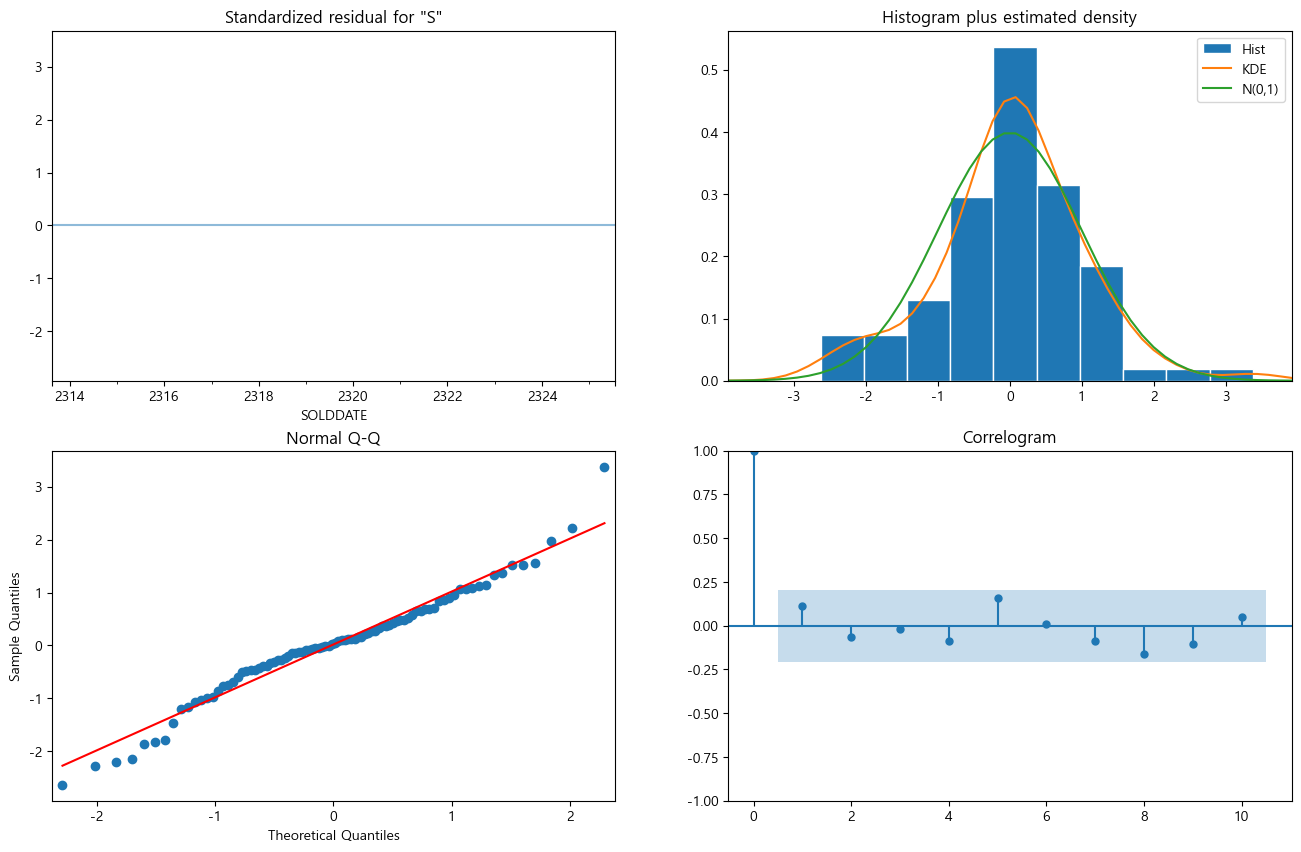

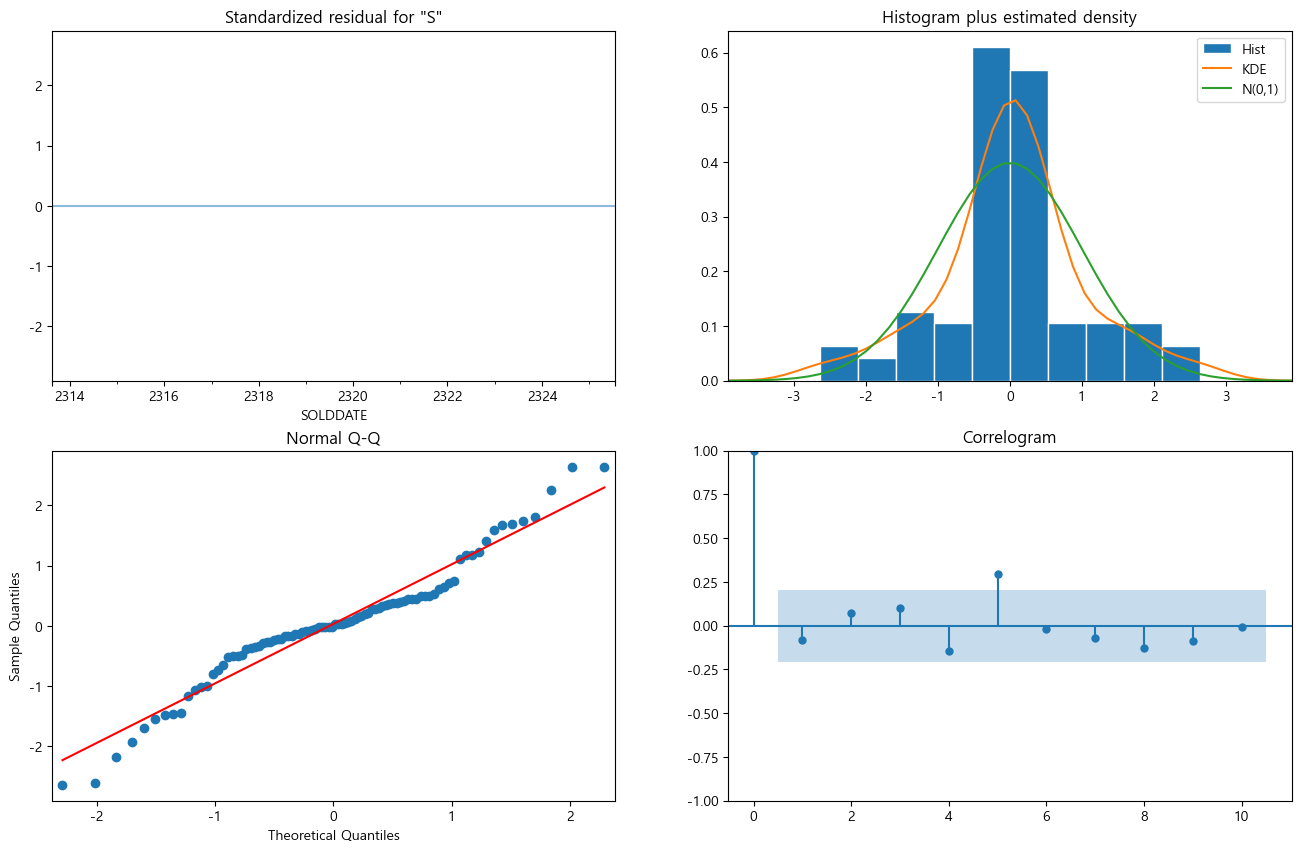

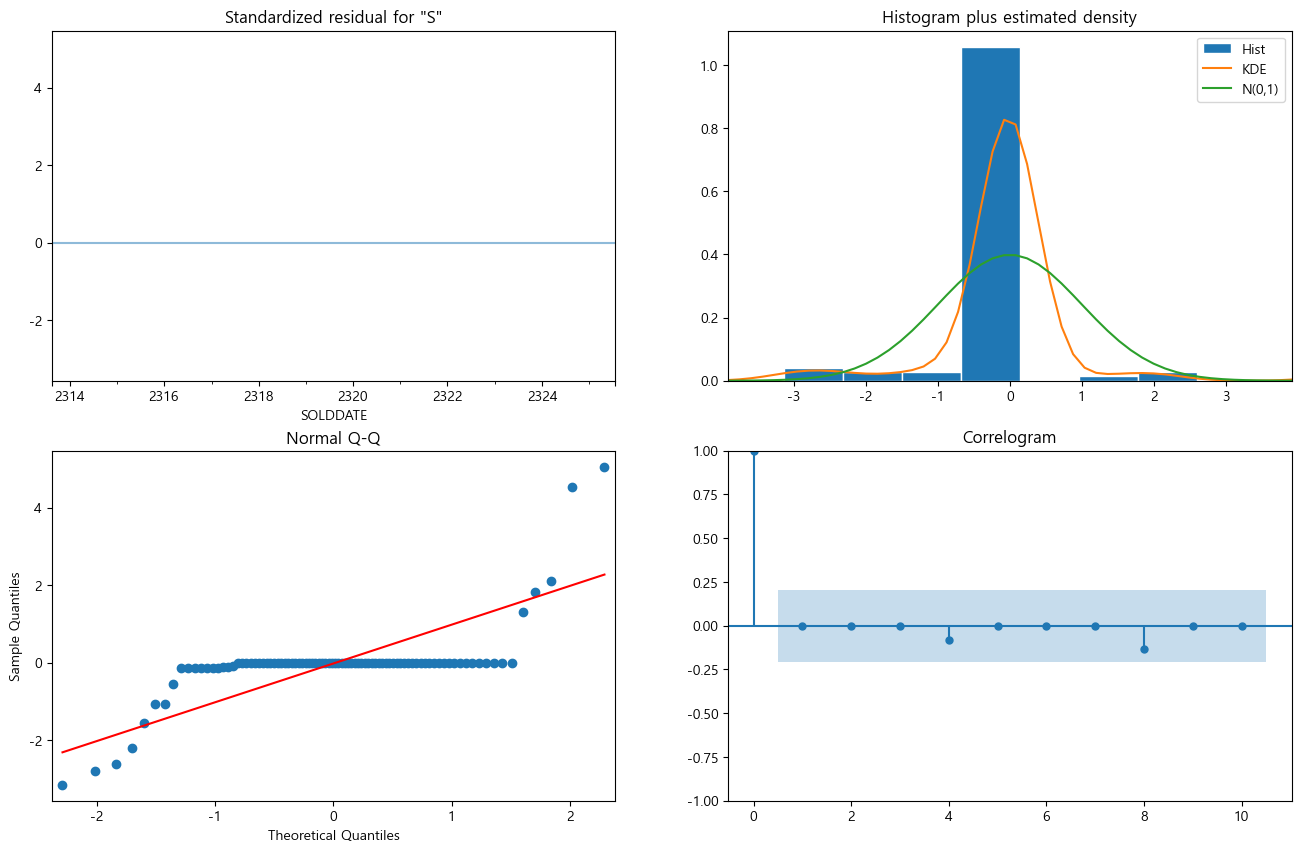

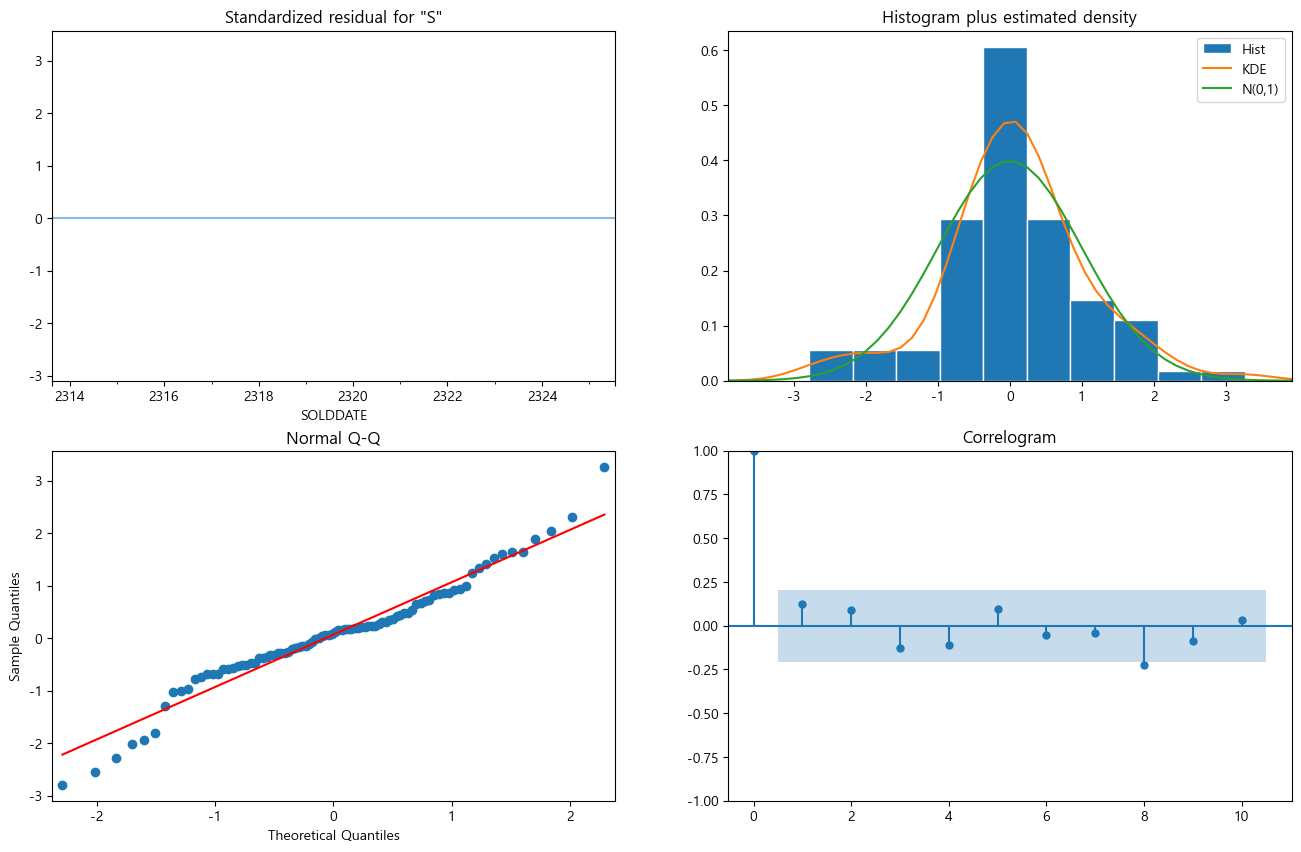

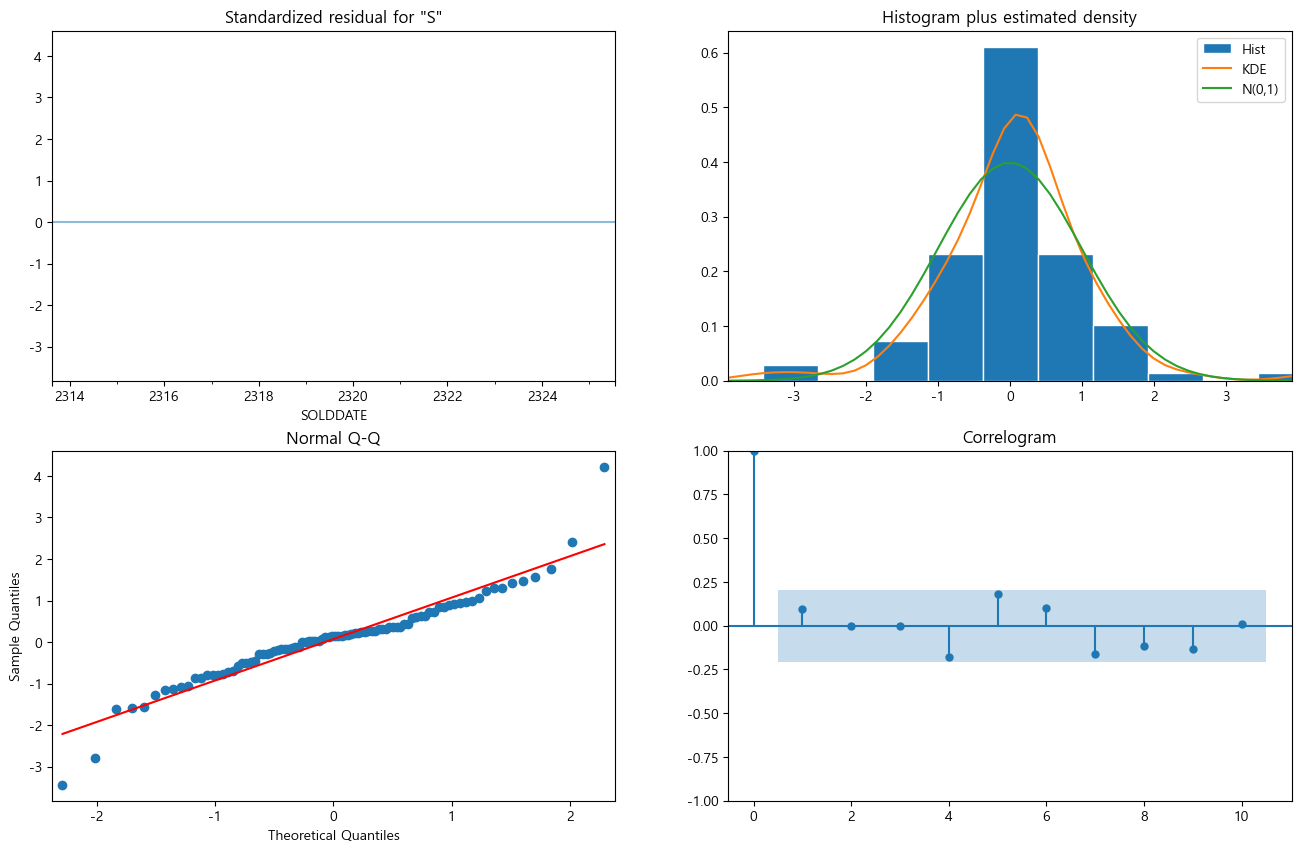

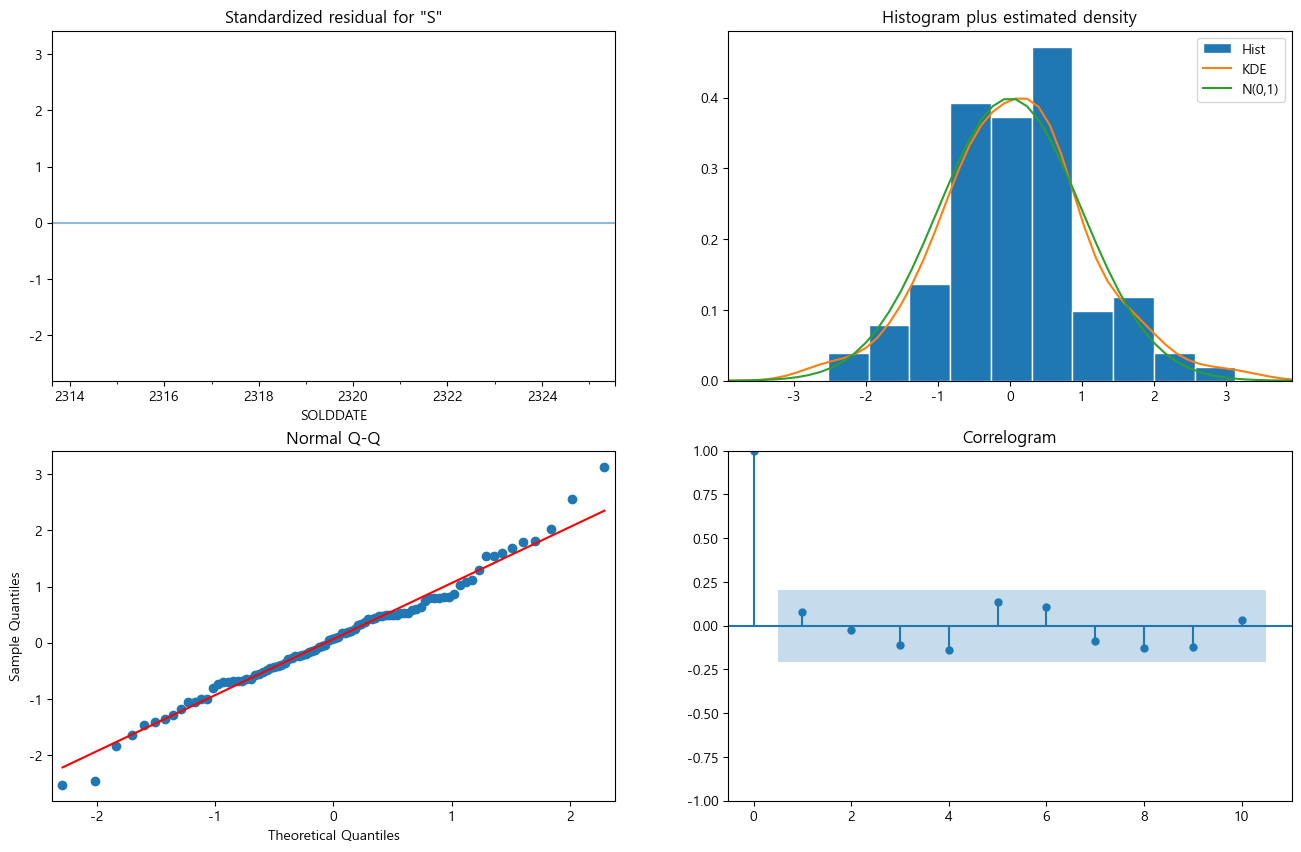

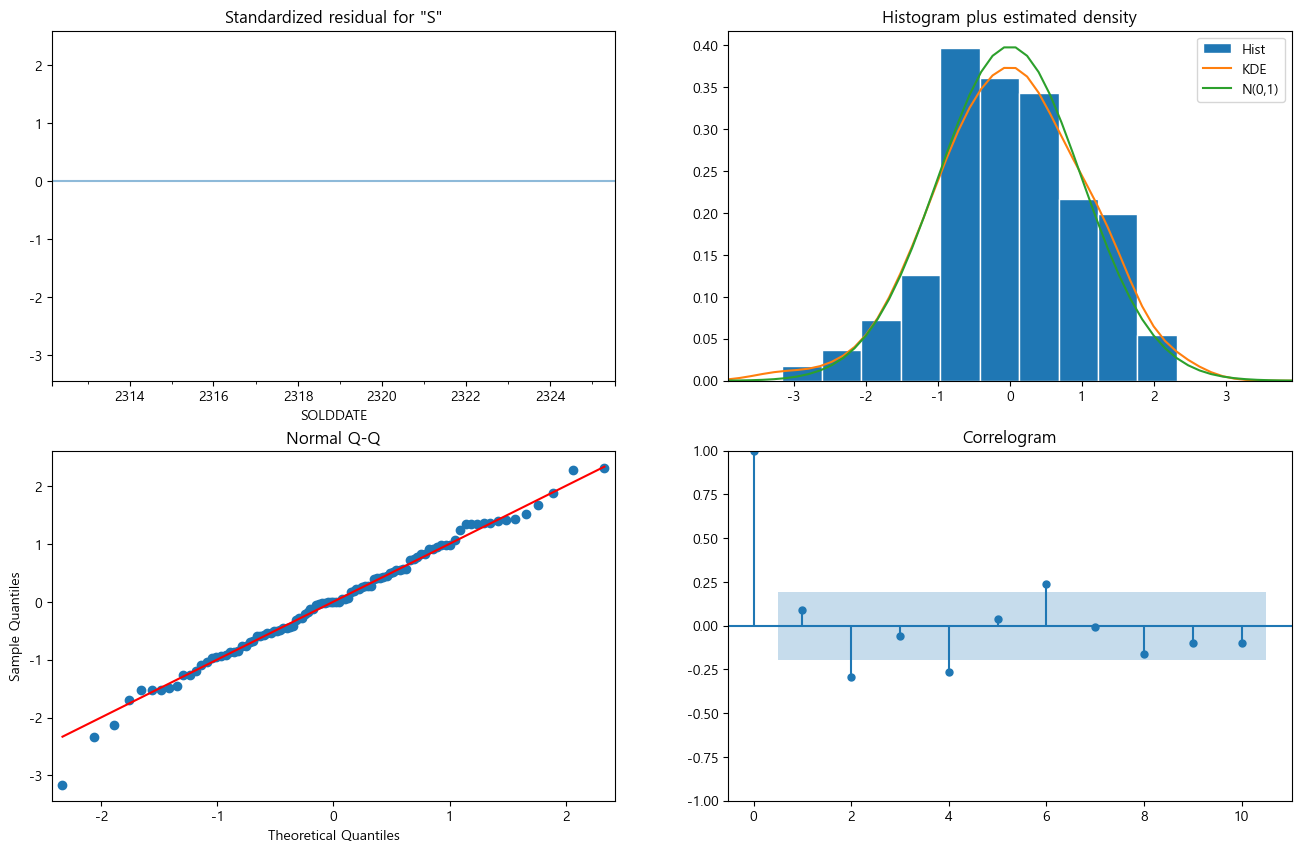

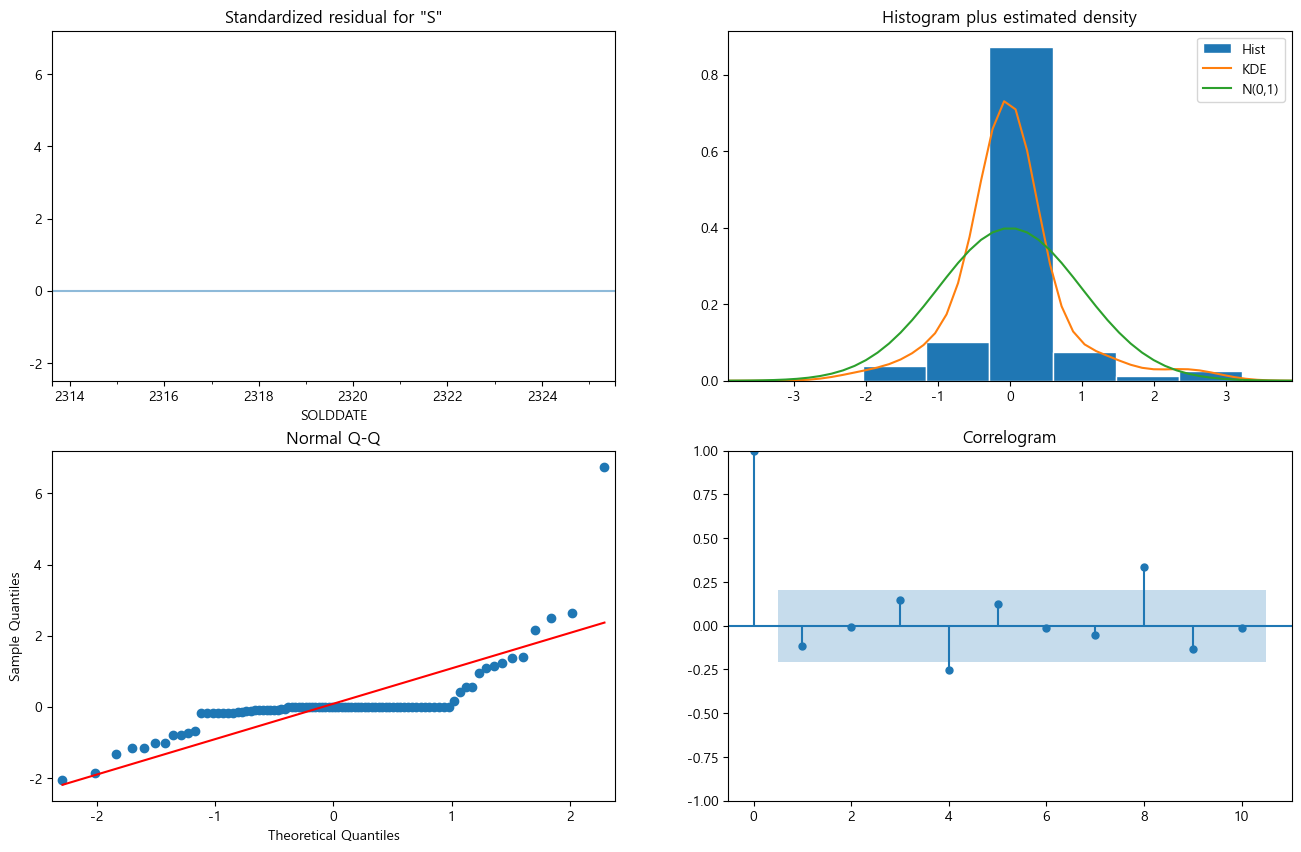

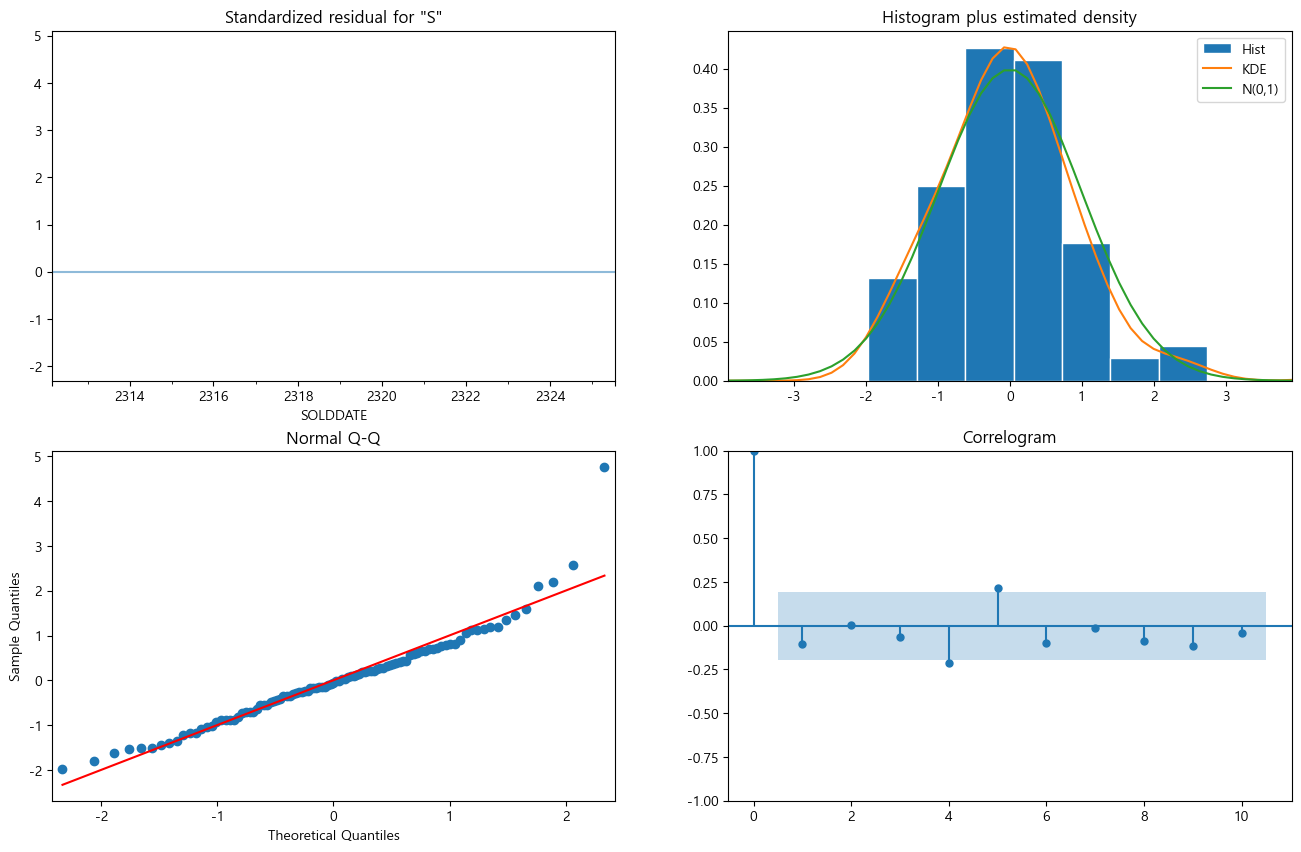

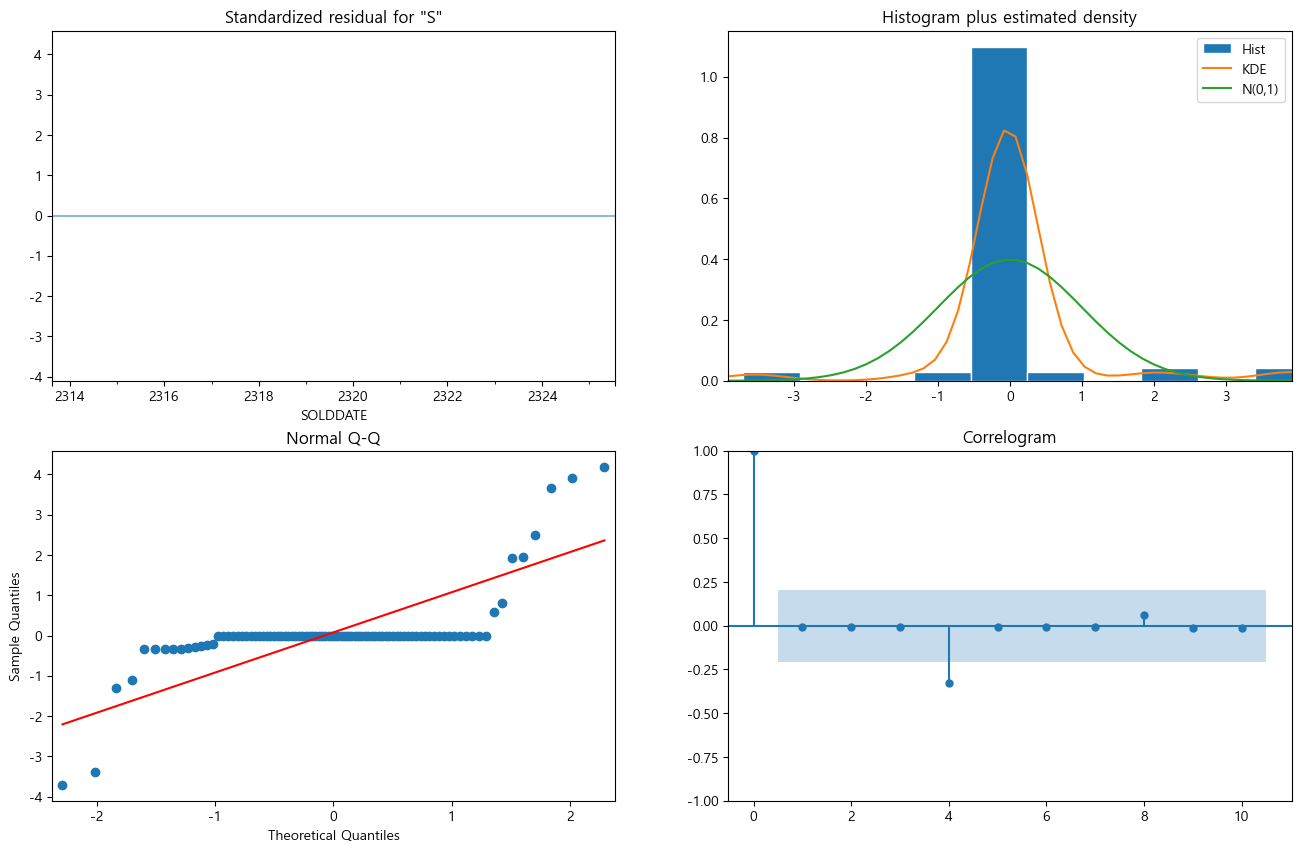

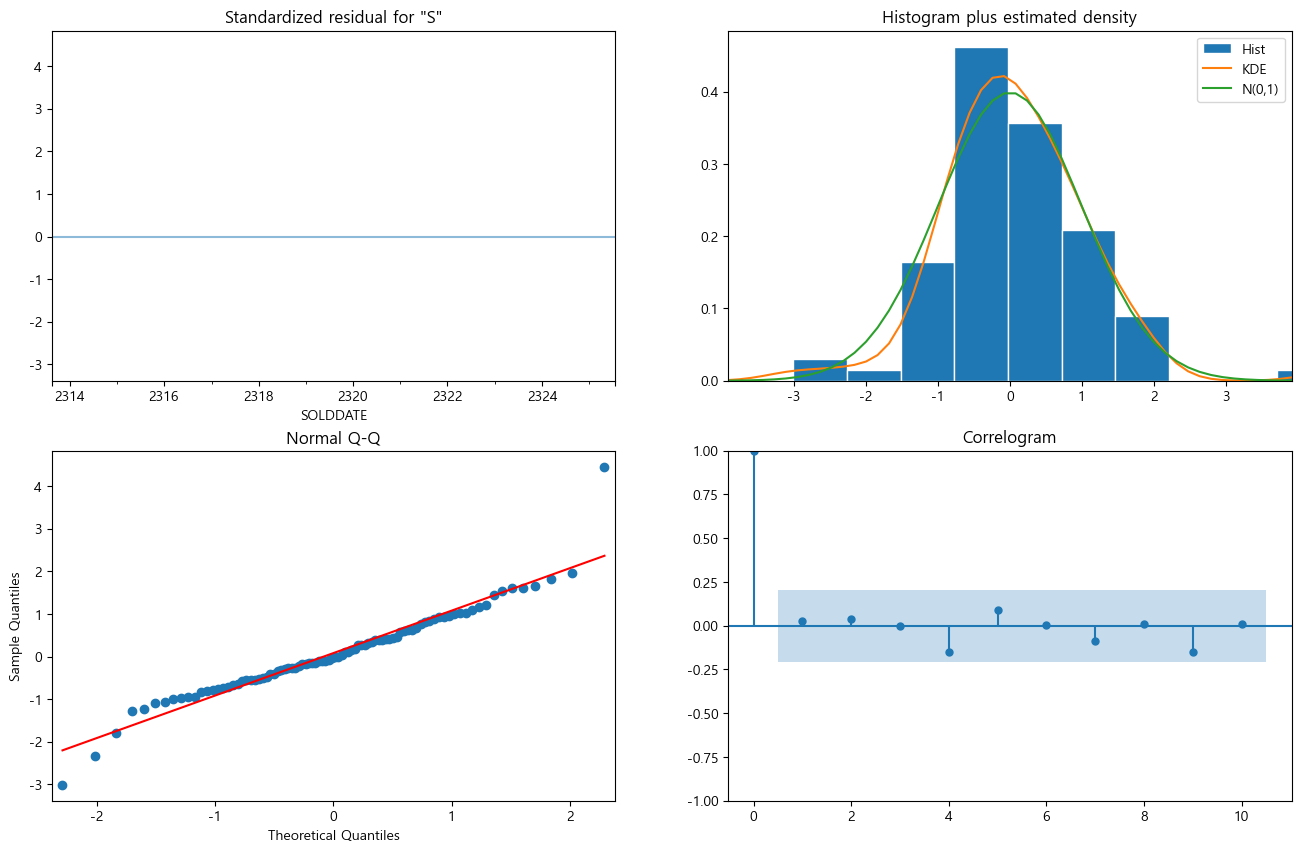

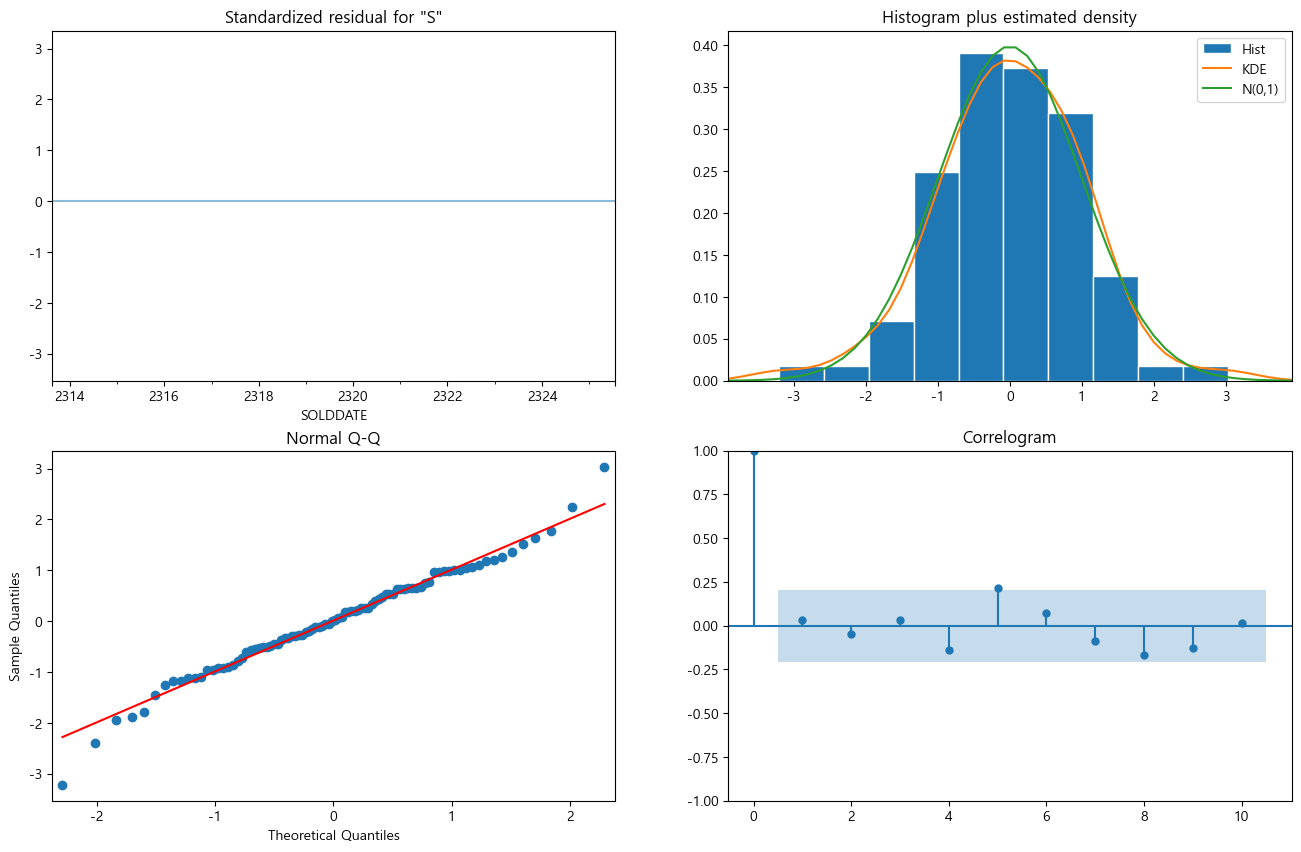

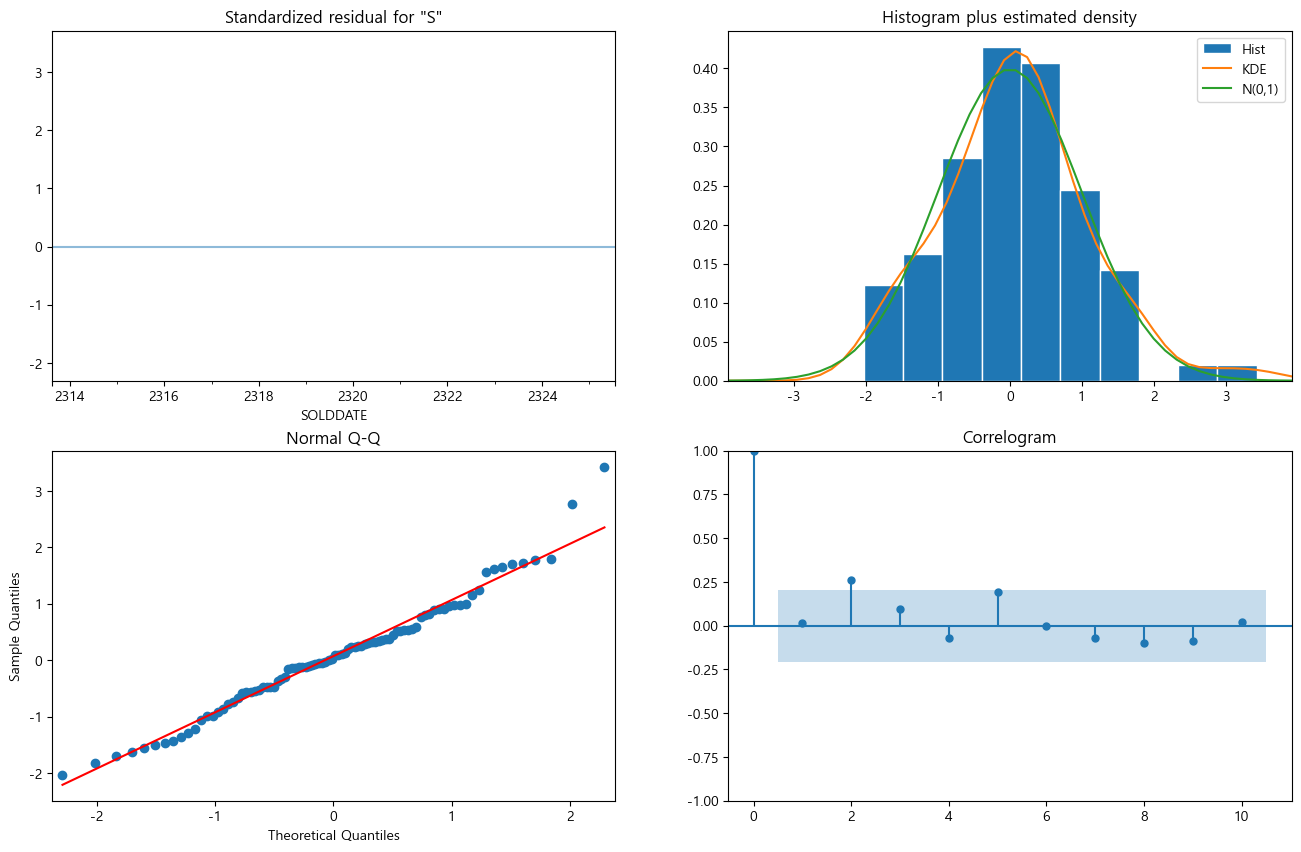

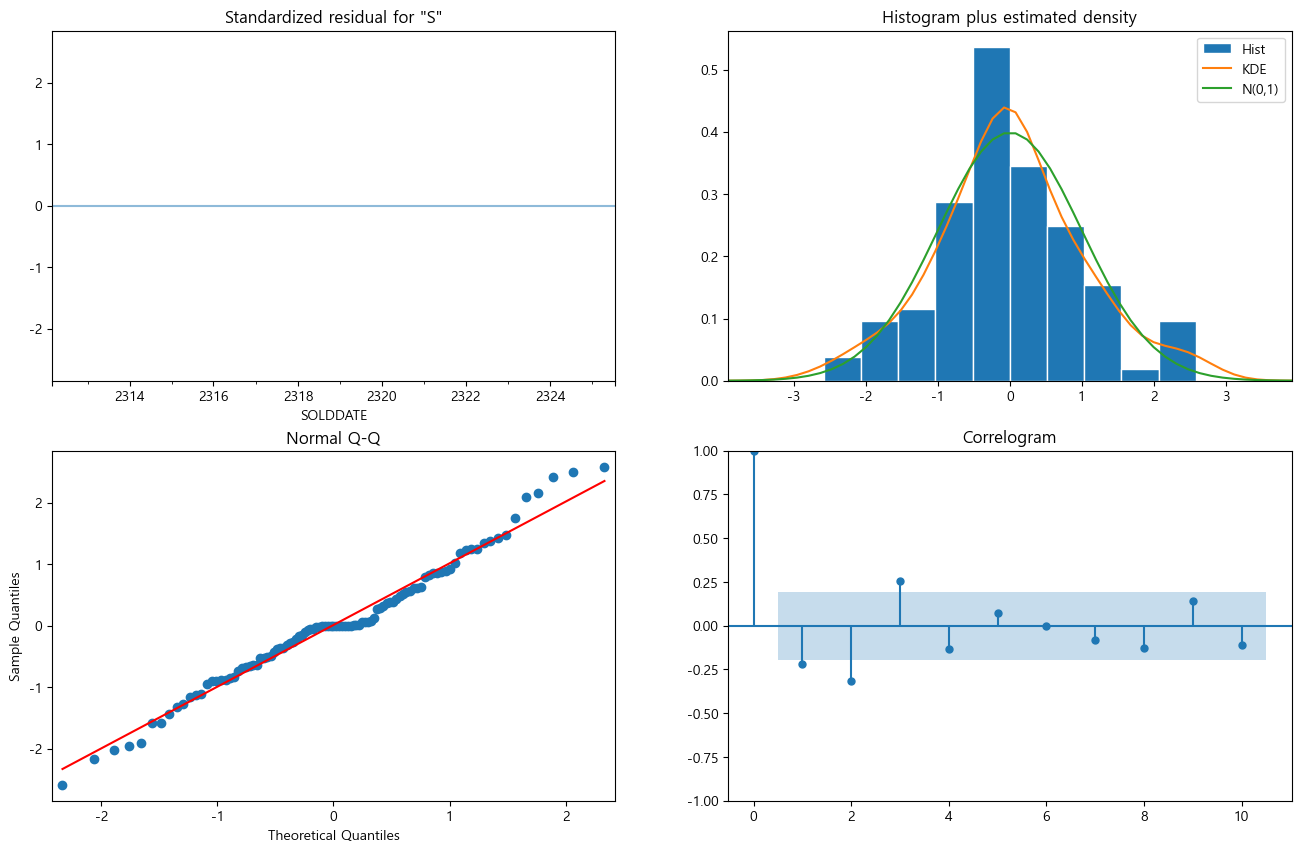

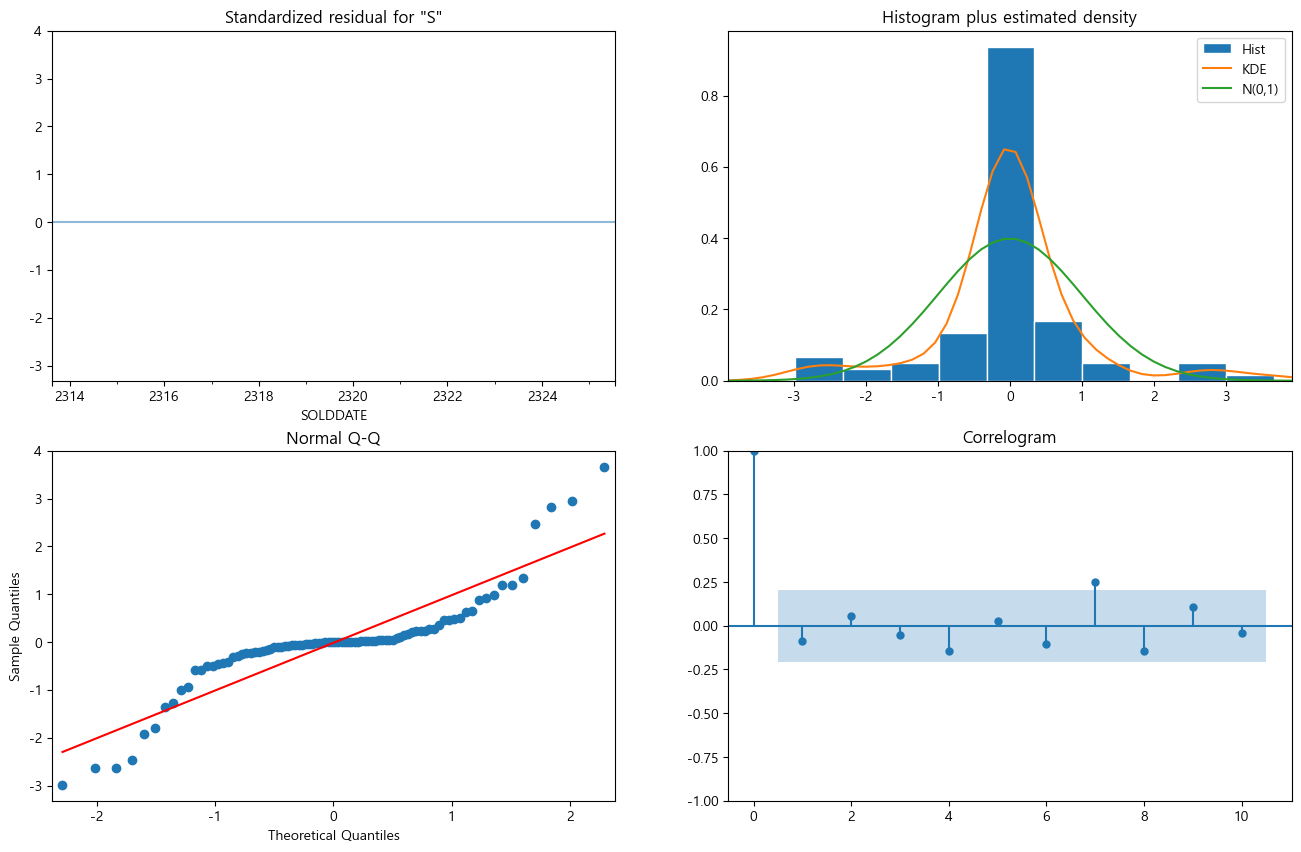

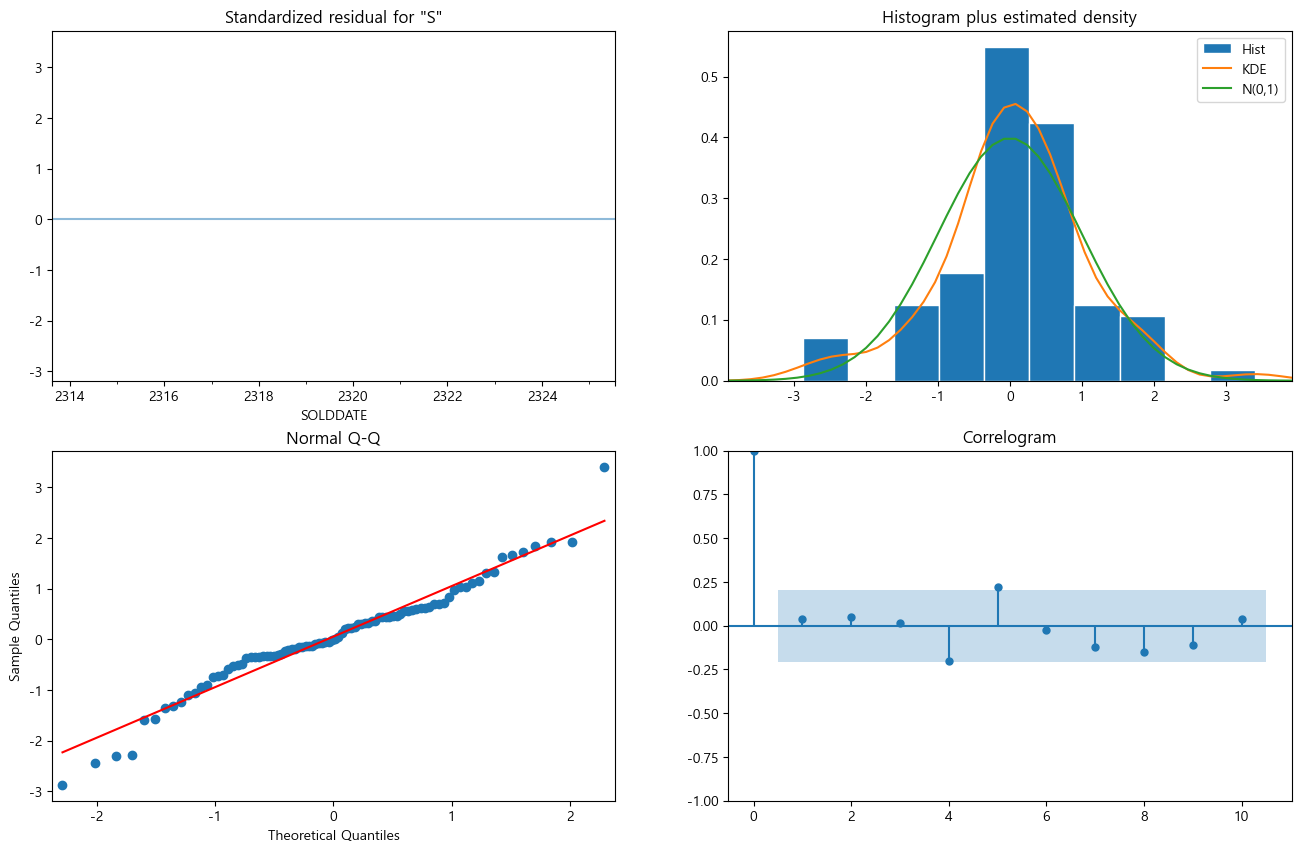

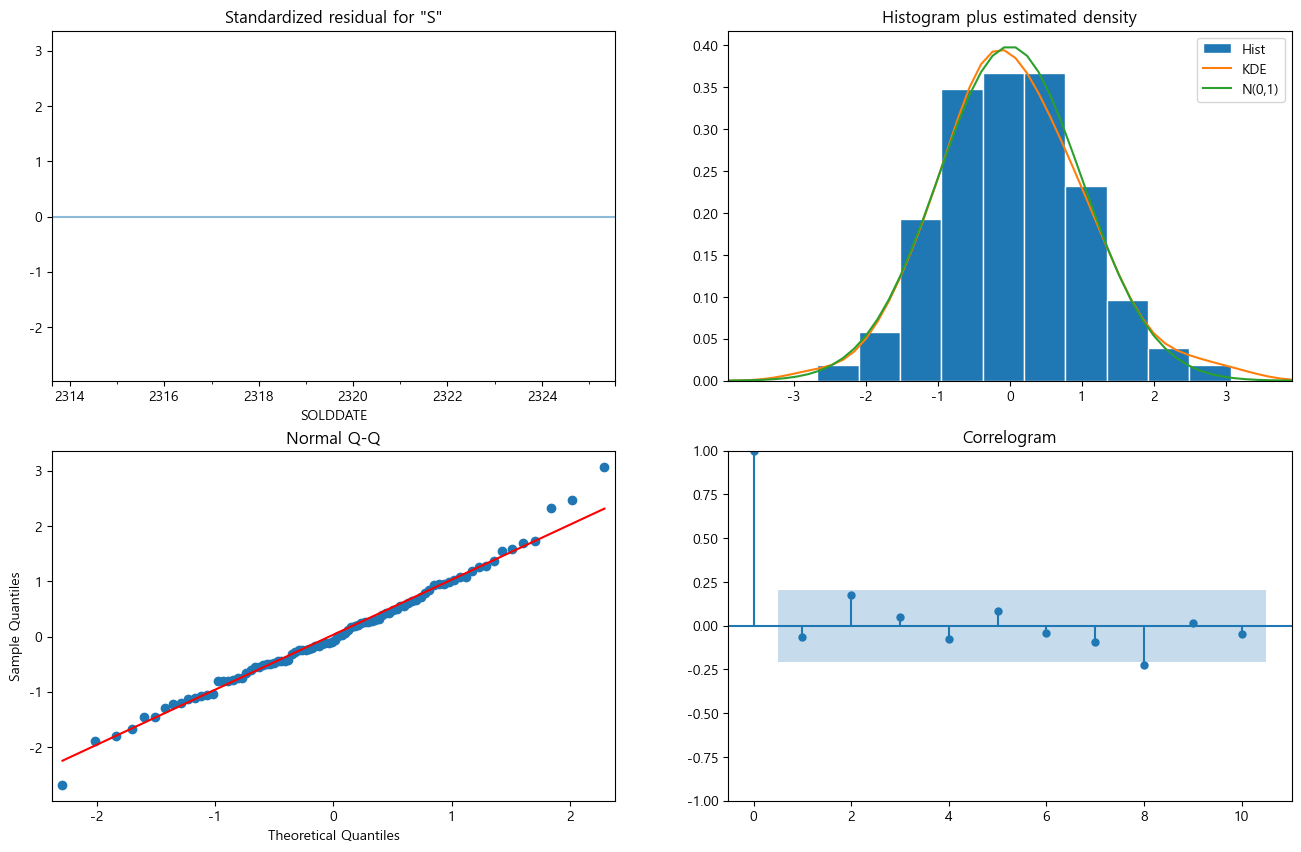

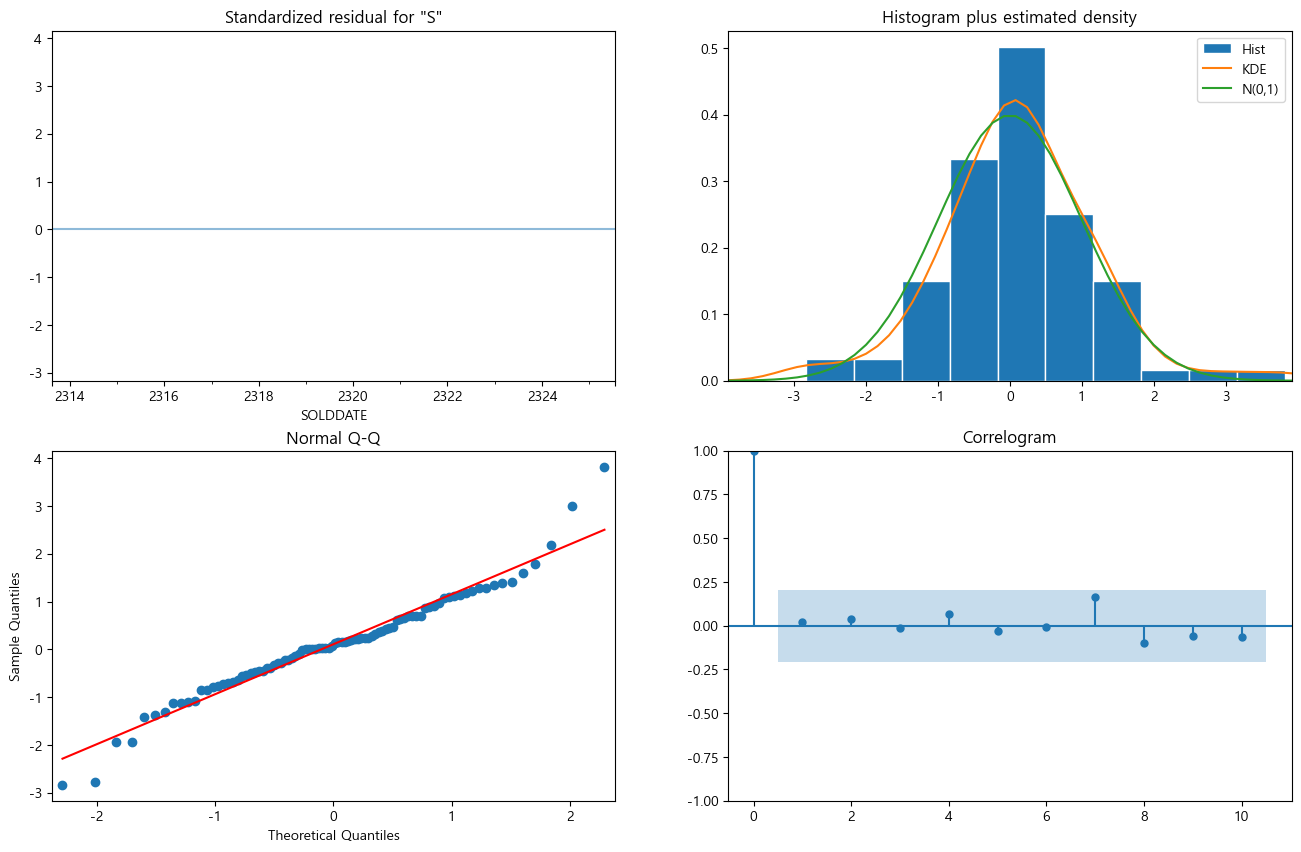

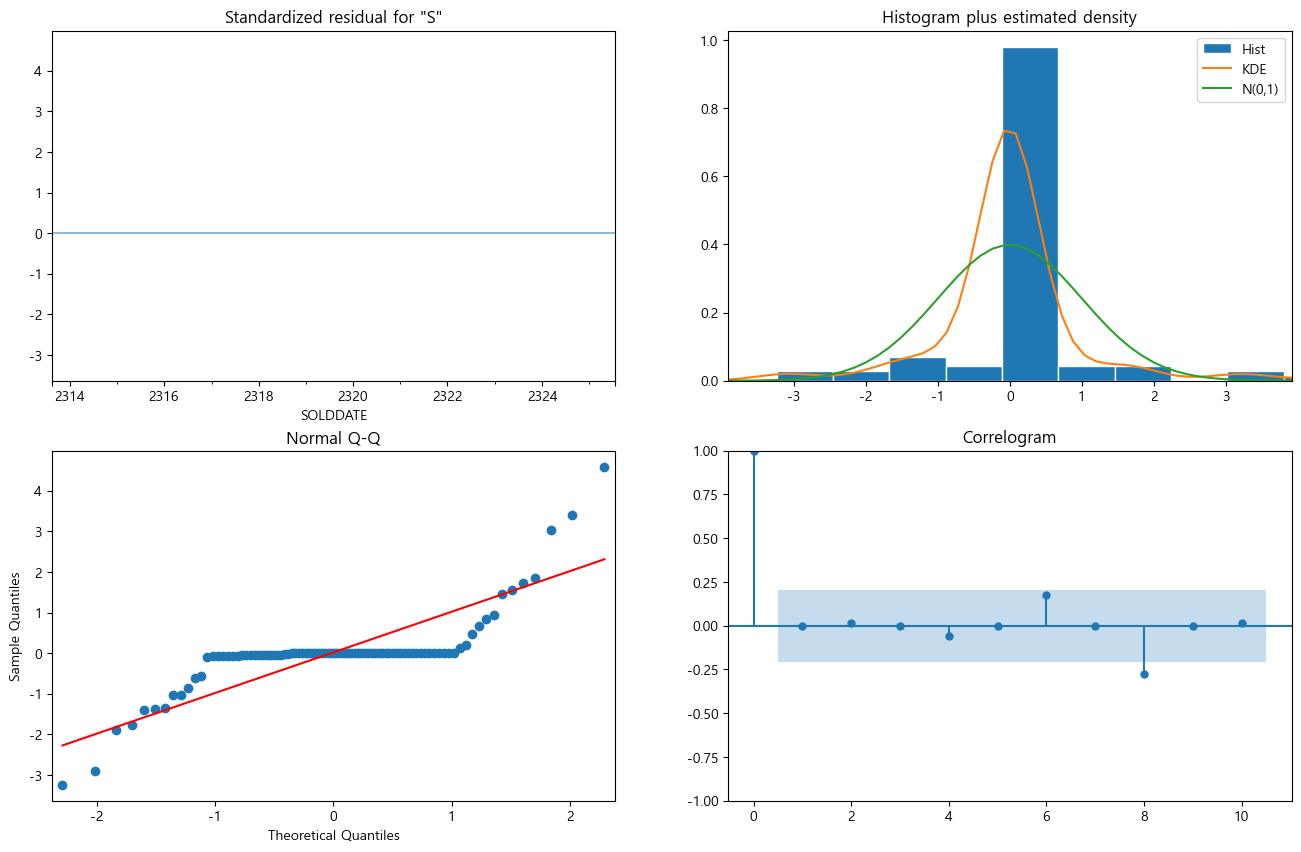

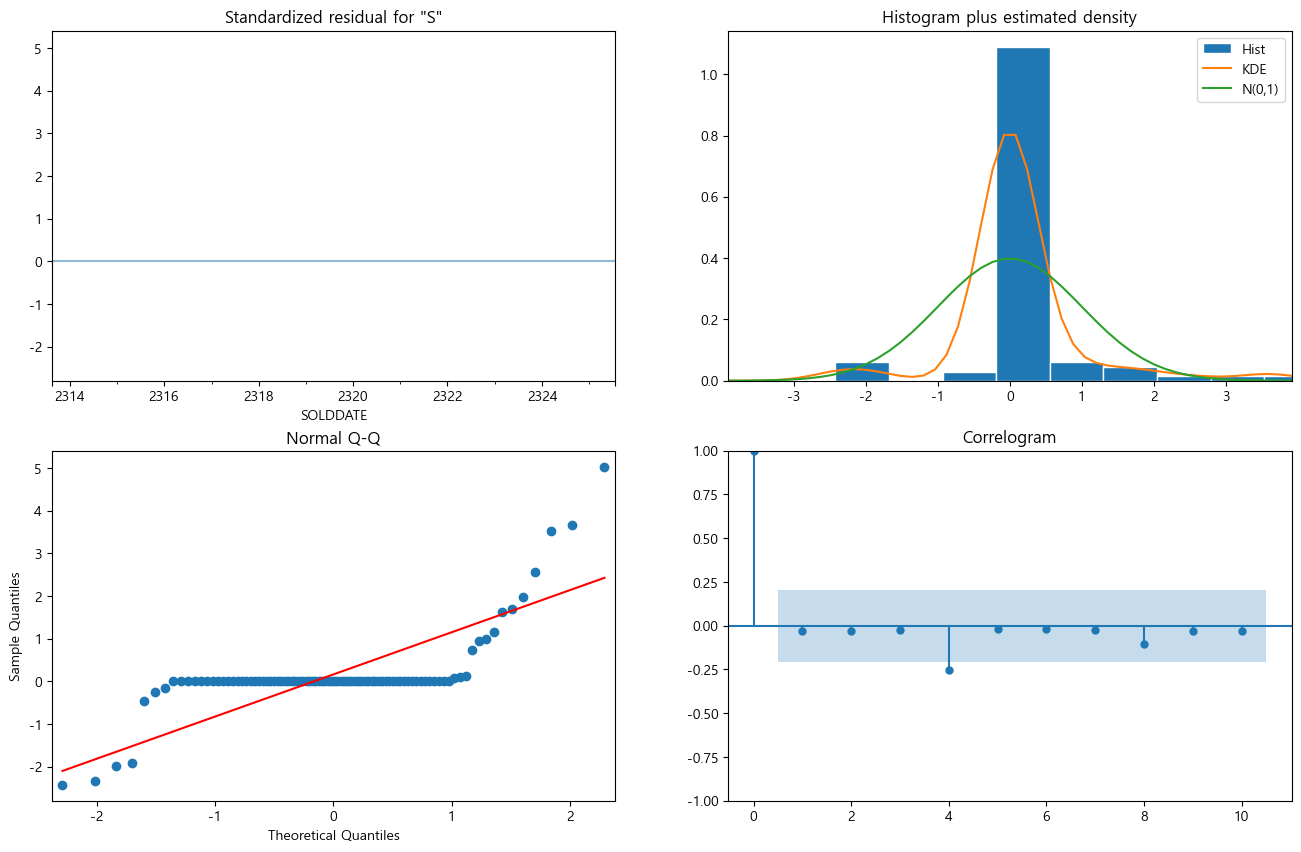

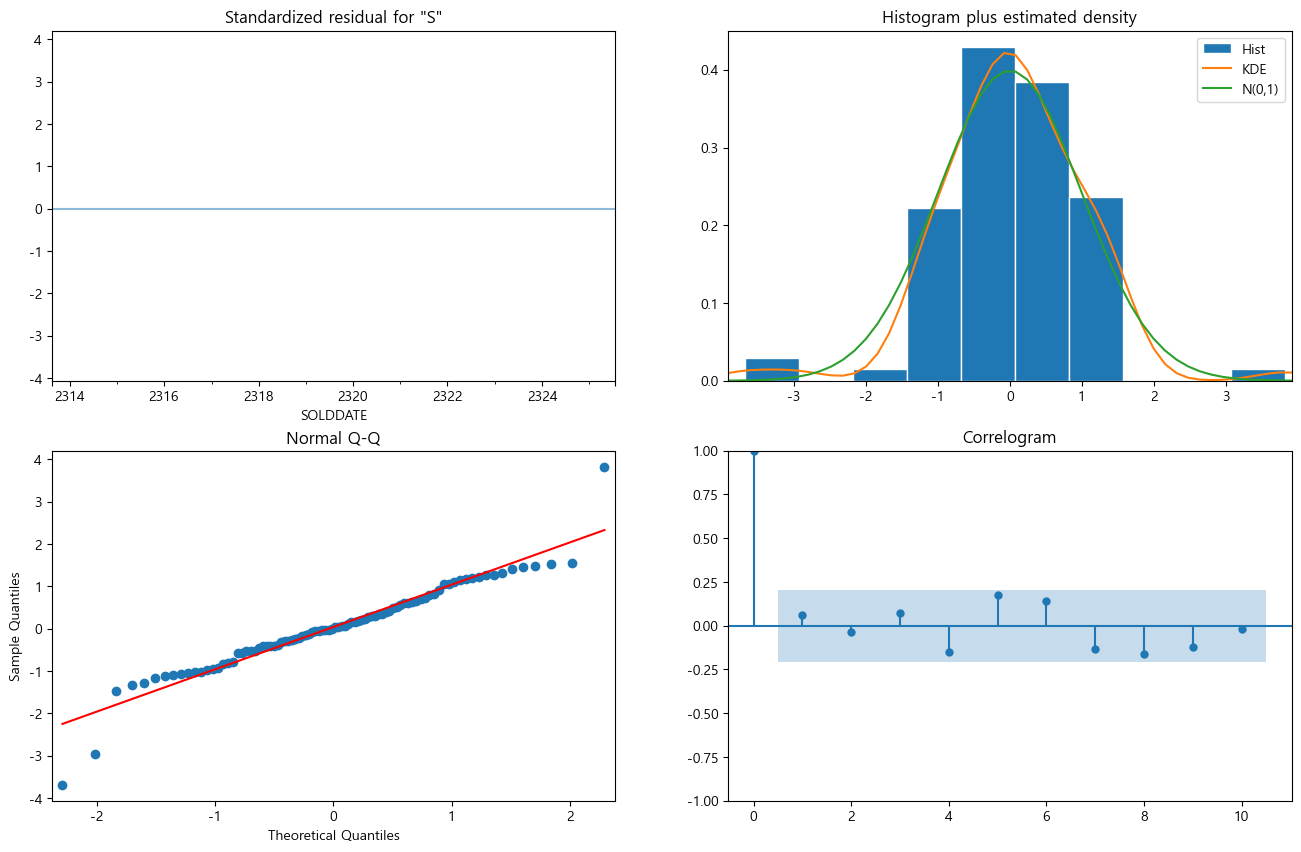

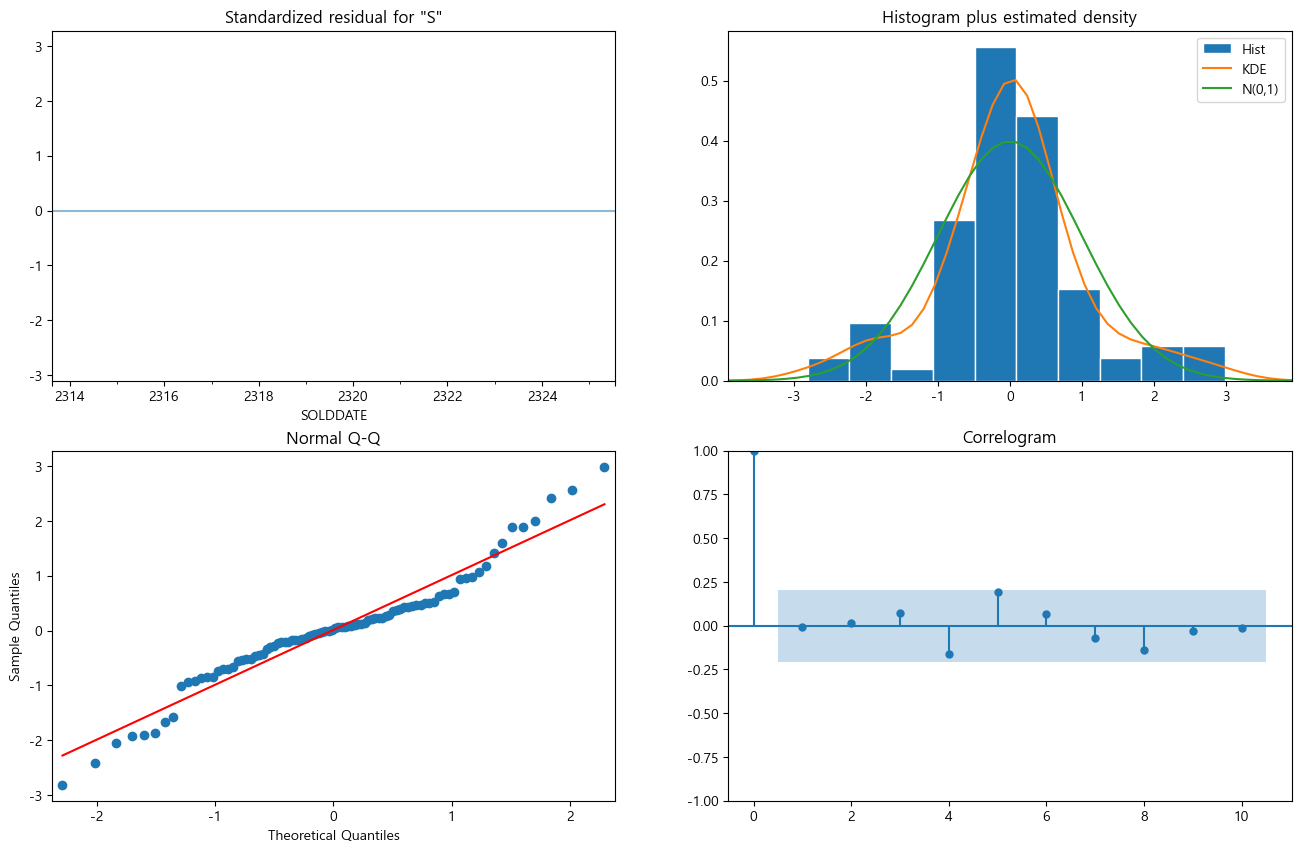

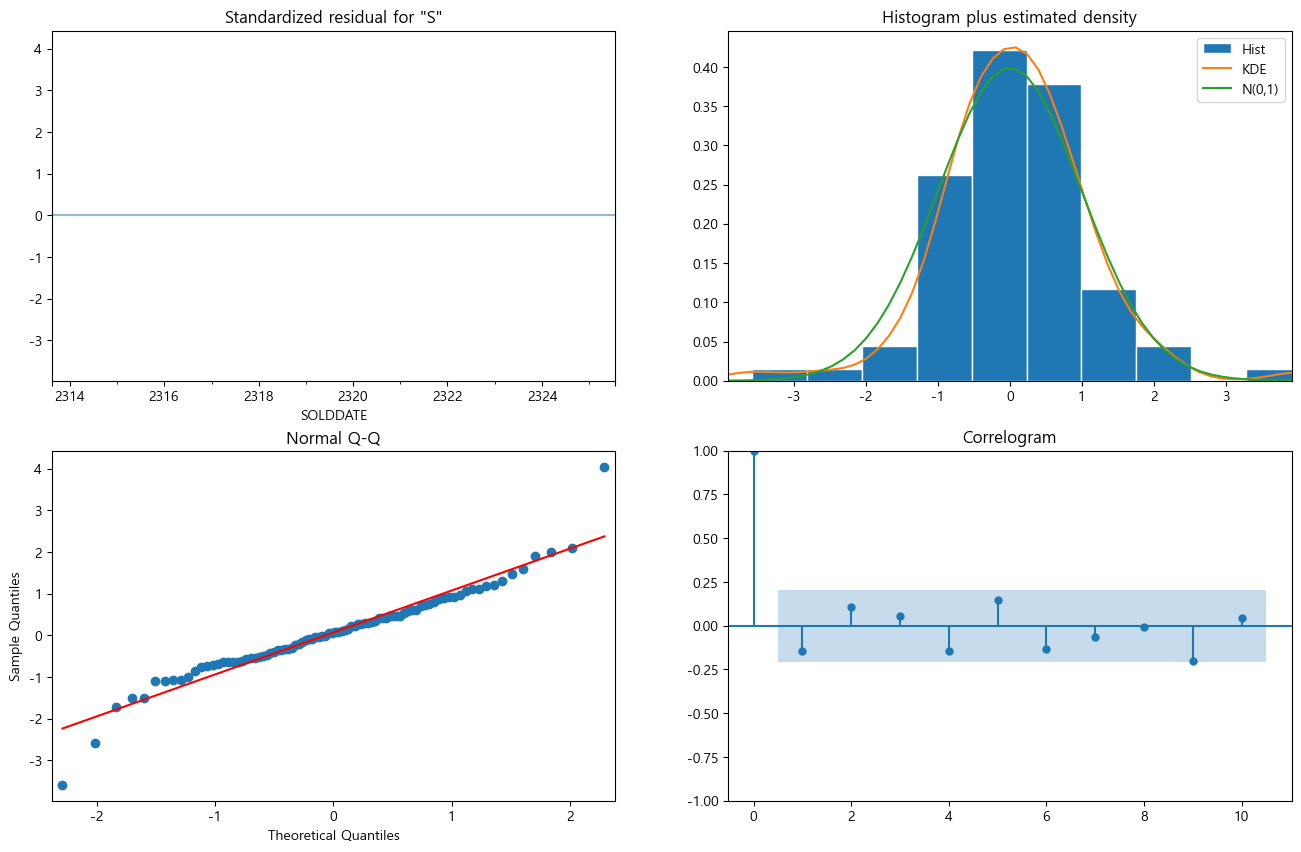

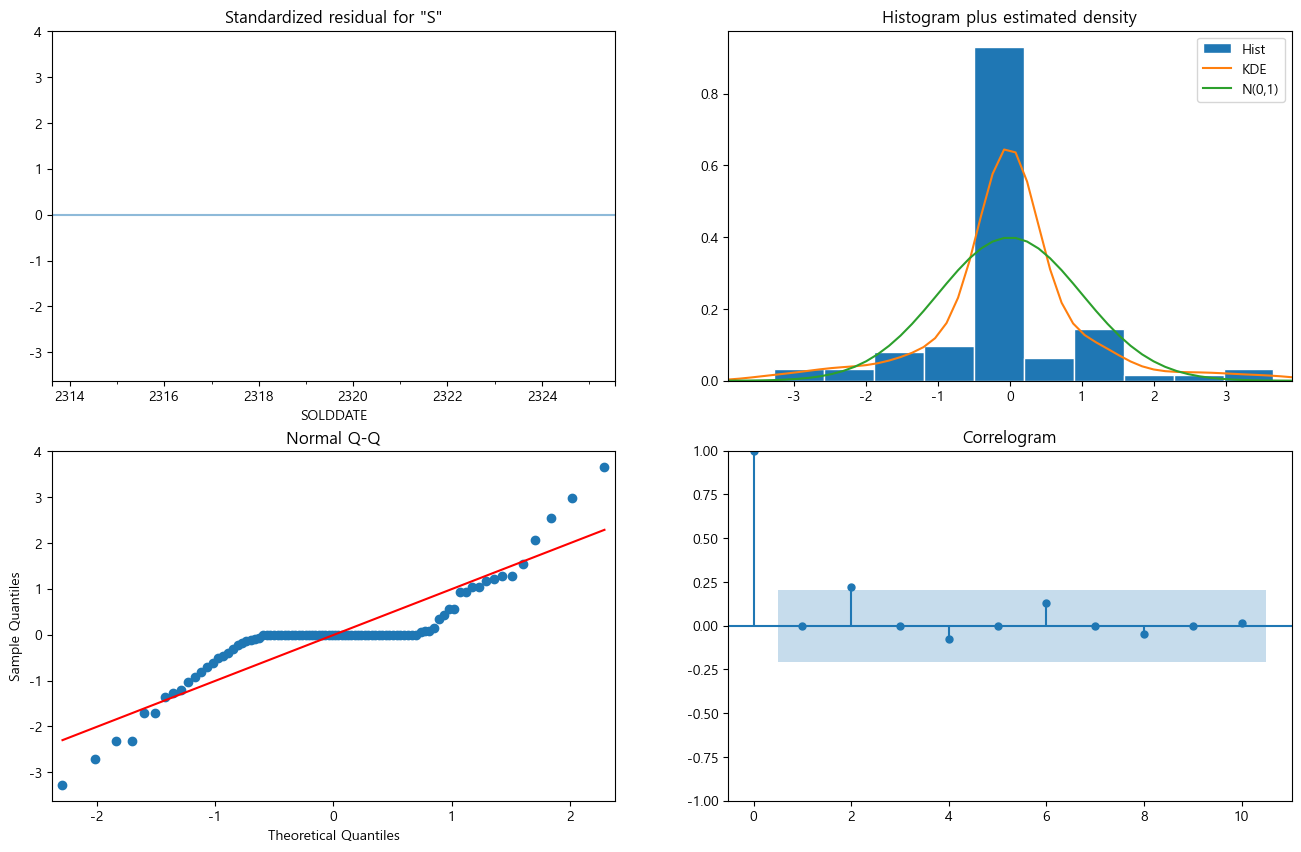

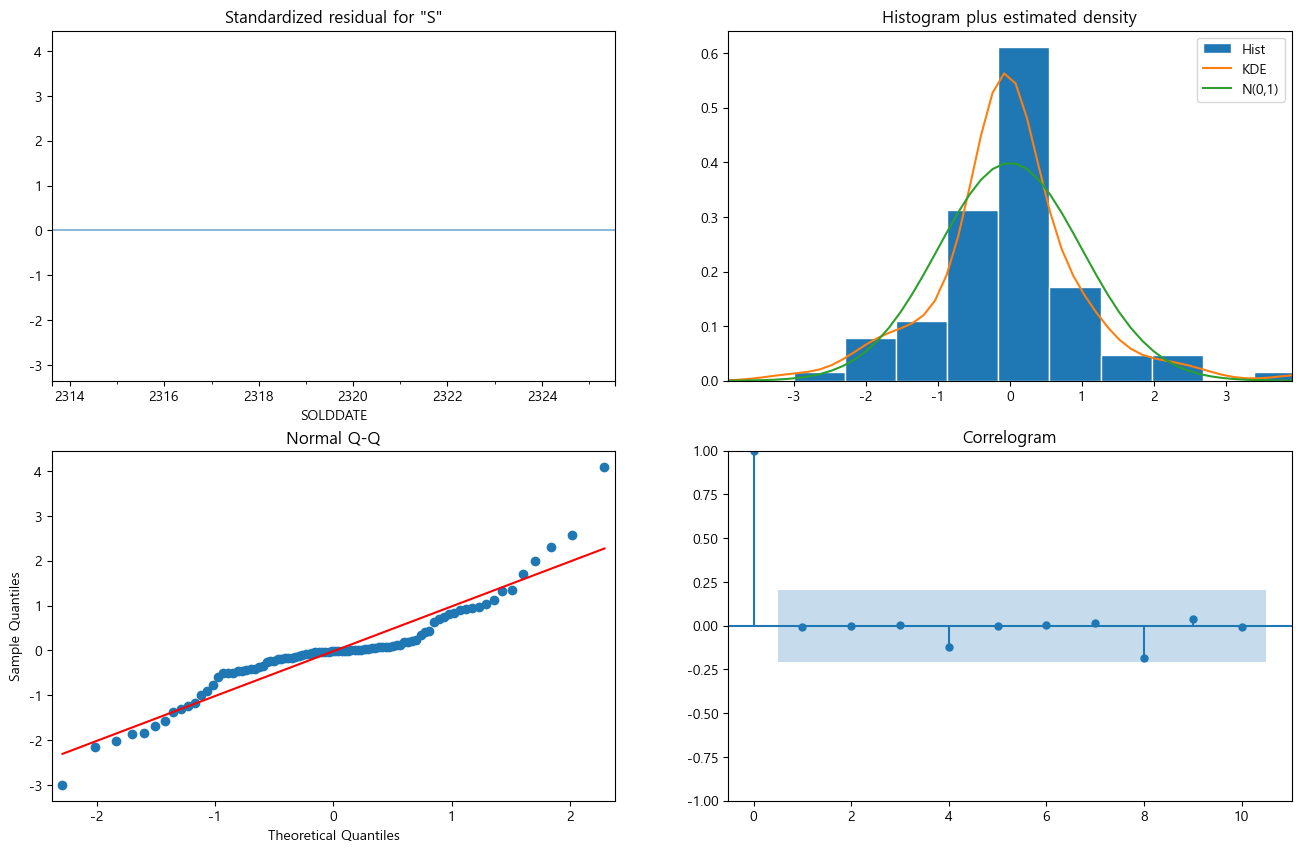

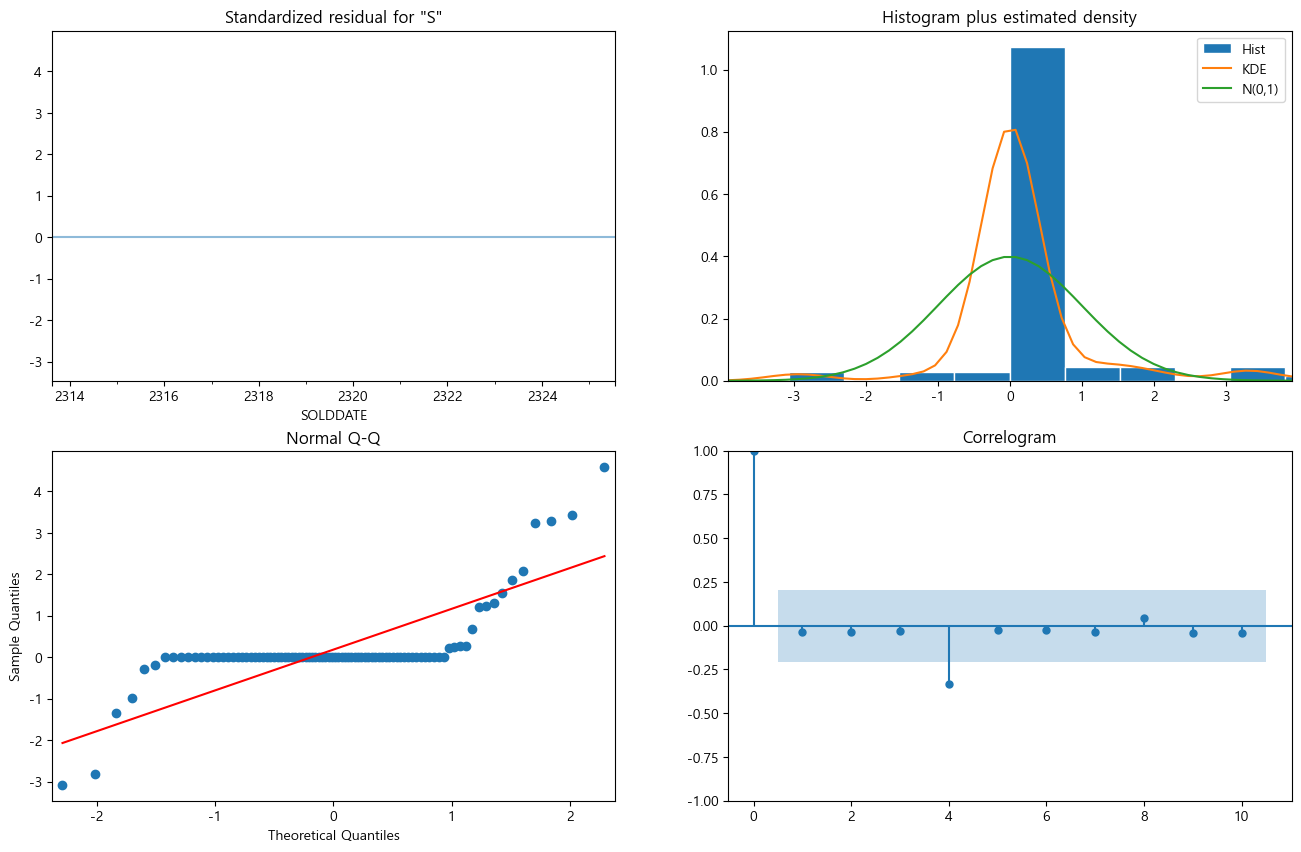

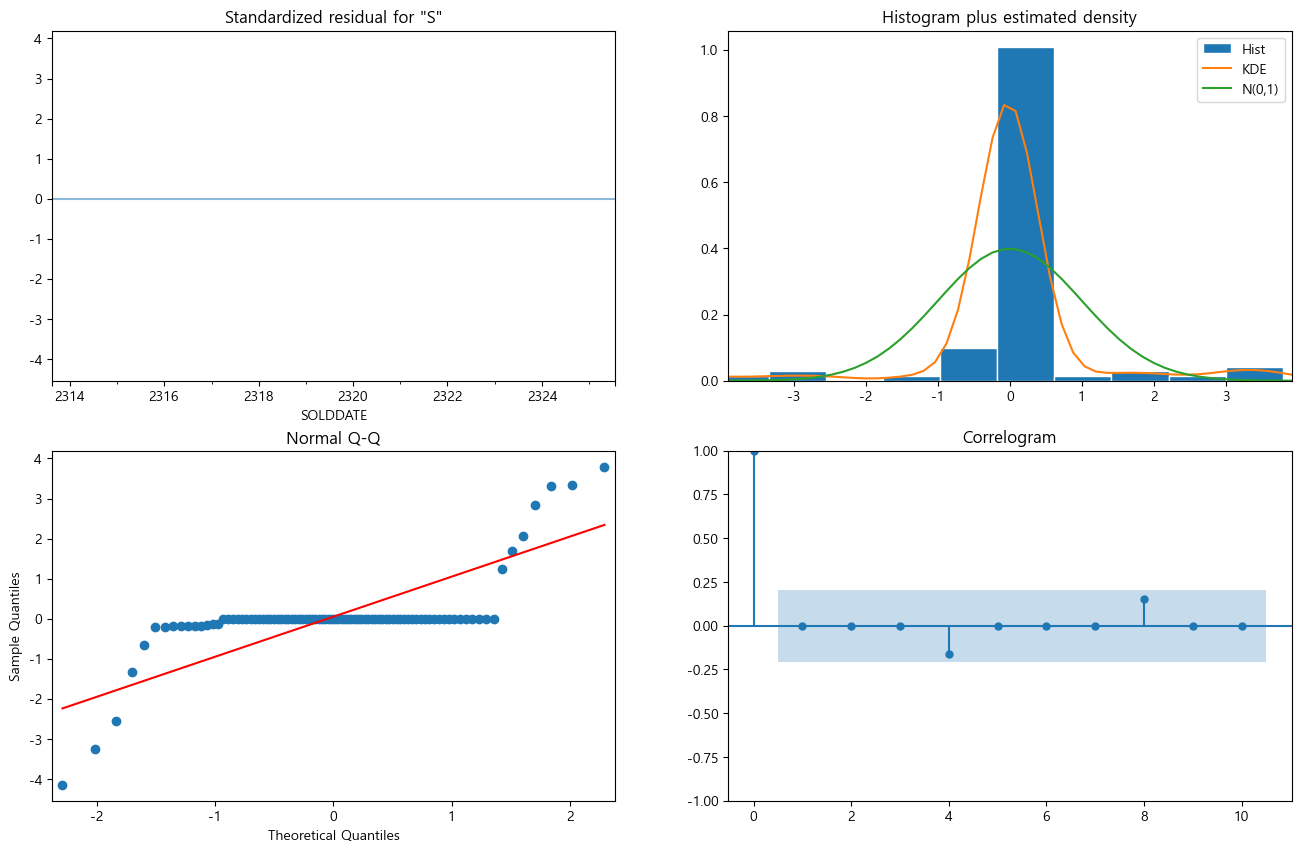

In [20]:
predicted_values_dic = {}
pdq_li = []
r2_li = []
aic_li = []
period = []
r2_remove0_li = []

for i in range(1):
  print('train  :',traindate_start.date(),'~',traindate_end.date())
  print('test   :',testdate_start.date(),'~',std_date.date())
  r2_li1 = []
  r2_remove0_li1 = []
  aic_li1 = []
  pdq_li1 = []
  period.append(testdate_start.strftime('%y%m%d')+'~'+std_date.strftime('%y%m%d'))

  for prod in co_df['PRODNAME'].unique():
    print(f'<<<<<<<<<<<<<<<  {prod}({testdate_start.date()} ~ {std_date.date()})  >>>>>>>>>>>>>>>')
    series = co_df.query(f'PRODNAME=="{prod}"')
    series.drop('PRODNAME',axis=1,inplace=True)
    series = series.resample('W').sum()

    # 데이터 분리

    train = series['SOLD_QUANT'][traindate_start:traindate_end]
    test = series['SOLD_QUANT'][testdate_start:std_date]


    # Grid_search

    p = d = q = range(0,2)
    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]
    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    tmp_model = None
    best_mdl = None

    for param in pdq:
      for param_seasonal in seasonal_pdq:
        try:
          tmp_mdl = sm.tsa.statespace.SARIMAX(train, exog=None, order=param,
                                              seasonal_order = param_seasonal,
                                              enforce_stationarity=True,
                                              enforce_invertibility=True)
          res = tmp_mdl.fit()
          if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = param
            best_seasonal_pdq = param_seasonal
            best_mdl = tmp_mdl
        except:
          continue
    print("Best SARIMAX{}x{}12 model - AIC : {}".format(best_pdq, best_seasonal_pdq, best_aic))

    # 학습

    res = sm.tsa.statespace.SARIMAX(endog=train, order=best_pdq,
                                seasonal_order = best_seasonal_pdq,
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()

    aic_li1.append(res.aic)
    pdq_li1.append((best_pdq, best_seasonal_pdq, best_aic))
    display(res.summary())

    try:
      res.plot_diagnostics(figsize=(16,10))
    except:
      pass

    # 시각화

    pred = res.get_prediction(start=test.index.min(),
                            end = test.index.max(),
                            dynamic=True)

    pred_ci = pred.conf_int()

#     plt.figure(figsize=(14,7))
#     ax = series[traindate_start:std_date].plot(label = 'Observed',color='#006699');
#     pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=.7, color='#ff0066');

#     ax.fill_between(pred_ci.index,
#                     pred_ci.iloc[:,0],
#                     pred_ci.iloc[:,1],color='#ff0066', alpha=.25);

#     ax.fill_betweenx(ax.get_ylim(), test.index.min(),
#                     test.index.max(), alpha=.15, zorder=-1,
#                     color='gray')
#     ax.set_xlabel('Time (week)')
#     ax.set_ylabel(f'weekly SOLD_QUANT({prod})')
#     ax.set_title('Test data vs prediction By SARIMA')
#     plt.legend(loc='upper left')
#     plt.show()

    # 검증(R2_score)

    from sklearn.metrics import r2_score
    predicted_value = pred.predicted_mean
    r2 = r2_score(test,predicted_value)
    r2_li1.append(r2)
    print('R2_score :',r2)
    print()
    print()

    # 모델, 결과값 저장

    res.save(f'D:\\hmkd1\\2차 프로젝트\\pkl\\test_pkl2\\{prod}{i}.pkl')
#     res.save(f'D:\\pythonscript\\2차 프로젝트\\pkl\\{prod}{i}.pkl')
    try:
      df = pd.concat([predicted_value,test],axis=1)
      df.to_excel(f'D:\\hmkd1\\2차 프로젝트\\pkl\\test_pkl2\\{prod}{i}.xlsx')
#       df.to_excel(f'D:\\pythonscript\\2차 프로젝트\\pkl\\{prod}{i}.xlsx')
      predicted_values_dic[f'{prod}{i+1}'] = df
      df1 = df[df['SOLD_QUANT']!=0]
      r2_remove0_li1.append(r2_score(df1['SOLD_QUANT'],df1[0]))
    except:
      predicted_values_dic[f'{prod}{i}'] = predicted_value

  print('='*80)
  r2_li.append(r2_li1)
  aic_li.append(aic_li1)
  pdq_li.append(pdq_li1)
  r2_remove0_li.append(r2_remove0_li1)

In [17]:
products = co_df['PRODNAME'].unique()
print(products)

['AE' 'CSA4000' 'CSA4000(PCA)' 'CSA5000' 'PEMA-500FR' 'PEMA-580FX'
 'PEMA-CR1000' 'PEMA-CSA5000' 'PEMA-HR1000' 'PEMA-HR1000S' 'PEMA-HR1500'
 'PEMA-PCM2000' 'PEMA-PCM2000B' 'PEMA-PCR3000E' 'PEMA-PCR3000N'
 'PEMA-PR1000' 'PEMA-PR2000' 'PEMA-SN400' 'PEMA-SP1000' 'PEMA-SPR'
 'PEMA-SR2000' 'PEMA-SR2000A' 'PEMA-SR3000F' 'PEMA-SR5000F' 'PR1000'
 'SRE-110' 'SRE-200']


In [18]:
std_date = co_df.index[-1]
testdate_start = std_date - relativedelta(months=6)
traindate_end = testdate_start - relativedelta(days=1)
traindate_start = co_df.index[0]

In [19]:
week_std_date = std_date1.to_pydatetime()
week_mon_date = week_std_date + timedelta(days = (7 - week_std_date.weekday()))
next_mon_date = week_mon_date.strftime('%Y-%m-%d')

month_date = week_mon_date + relativedelta(months=3)

## 모델 불러와서 제품별 예측량 뽑기

In [21]:
import pandas as pd
import pickle
import re

products = co_df['PRODNAME'].unique()
result_dfs = []

for product in products:
    # 모델 불러오기
    with open(f'D:\\hmkd1\\2차 프로젝트\\pkl\\test_pkl2\\{product}0.pkl', 'rb') as file:
#     with open(f'D:\\pythonscript\\2차 프로젝트\\pkl\\test\\{product}0.pkl', 'rb') as file:
        loaded_model = pickle.load(file)

    forecast_steps = 56
    forecast = loaded_model.get_forecast(steps=forecast_steps)
    forecast_values = forecast.predicted_mean
    df = pd.DataFrame(forecast_values, columns=['predicted_mean'])
    df['week'] = df.index - pd.Timedelta(days=6)
    df = df.set_index('week')
    df.rename(columns={'predicted_mean': '예측중량'}, inplace=True)
    
    start_date = next_mon_date
    end_date = month_date 

    filtered_df = df[(df.index >= start_date) & (df.index <= end_date)]
    
    filtered_df['prodname'] = product

    # 정규화된 데이터에서 최소값과 최대값을 구합니다.
    min_val = RRP['SOLD_QUANT'].min()
    max_val = RRP['SOLD_QUANT'].max()

    # 정규화된 값을 원본 범위로 스케일링합니다.
    filtered_df['예측중량'] = (filtered_df['예측중량'] * (max_val - min_val)) + min_val
    
    # 결과 데이터프레임을 리스트에 추가
    result_dfs.append(filtered_df)

final_result_df = pd.concat(result_dfs)

# 결과 데이터프레임 출력
print(final_result_df)

                    예측중량 prodname
week                             
2021-04-26  1.229002e+04       AE
2021-05-03  3.283300e+04       AE
2021-05-10  2.286166e+04       AE
2021-05-17  1.505384e+04       AE
2021-05-24  8.116336e+03       AE
...                  ...      ...
2021-06-28 -4.025973e-20  SRE-200
2021-07-05  5.476008e-19  SRE-200
2021-07-12  1.162451e+04  SRE-200
2021-07-19 -1.336069e-19  SRE-200
2021-07-26  5.224809e-20  SRE-200

[378 rows x 2 columns]


In [22]:
final_result_df = final_result_df.reset_index()

In [23]:
final_result_df

,week,예측중량,prodname
0,2021-04-26,1.229002e+04,AE
1,2021-05-03,3.283300e+04,AE
2,2021-05-10,2.286166e+04,AE
3,2021-05-17,1.505384e+04,AE
4,2021-05-24,8.116336e+03,AE
...,...,...,...
373,2021-06-28,-4.025973e-20,SRE-200
374,2021-07-05,5.476008e-19,SRE-200
375,2021-07-12,1.162451e+04,SRE-200
376,2021-07-19,-1.336069e-19,SRE-200


In [24]:
final_result_df['tem_avg'] = [None] * len(final_result_df)
final_result_df['hum_avg'] = [None] * len(final_result_df)
final_result_df['국내건설수주액'] = [None] * len(final_result_df)
final_result_df['국내기성액'] = [None] * len(final_result_df)

final_result_df

,week,예측중량,prodname,tem_avg,hum_avg,국내건설수주액,국내기성액
0,2021-04-26,1.229002e+04,AE,None,None,None,None
1,2021-05-03,3.283300e+04,AE,None,None,None,None
2,2021-05-10,2.286166e+04,AE,None,None,None,None
3,2021-05-17,1.505384e+04,AE,None,None,None,None
4,2021-05-24,8.116336e+03,AE,None,None,None,None
...,...,...,...,...,...,...,...
373,2021-06-28,-4.025973e-20,SRE-200,None,None,None,None
374,2021-07-05,5.476008e-19,SRE-200,None,None,None,None
375,2021-07-12,1.162451e+04,SRE-200,None,None,None,None
376,2021-07-19,-1.336069e-19,SRE-200,None,None,None,None


In [25]:
current_time = datetime.now()
# 현재시점을 불러옴
formatted__date = current_time.strftime("%Y%m")
# 건설api 형식으로 수정함 (년/월)
yesterday = current_time - timedelta(days=1)
# 어제시점을 불러옵니다 (기상청은 현재시점에 전날까지 업데이트)
w_date = yesterday.strftime("%Y%m%d")
# 기상청 api 형식으로 수정함(년/월/일)

In [26]:
print(formatted__date)
print(w_date)

202308
20230821


In [27]:
final_result_df

,week,예측중량,prodname,tem_avg,hum_avg,국내건설수주액,국내기성액
0,2021-04-26,1.229002e+04,AE,None,None,None,None
1,2021-05-03,3.283300e+04,AE,None,None,None,None
2,2021-05-10,2.286166e+04,AE,None,None,None,None
3,2021-05-17,1.505384e+04,AE,None,None,None,None
4,2021-05-24,8.116336e+03,AE,None,None,None,None
...,...,...,...,...,...,...,...
373,2021-06-28,-4.025973e-20,SRE-200,None,None,None,None
374,2021-07-05,5.476008e-19,SRE-200,None,None,None,None
375,2021-07-12,1.162451e+04,SRE-200,None,None,None,None
376,2021-07-19,-1.336069e-19,SRE-200,None,None,None,None


In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from lxml import etree
import json
import requests
import xml.etree.ElementTree as ET
from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus, unquote
import pprint
from pandas import DataFrame
import datetime
from datetime import datetime, timedelta


data_dict = {
    '901Y104' : '건설기성액',
    '901Y020' : '국내건설수주액'
}

KEY = 'P6B82DH7S3NJPJF38DPV'
PERIOD = 'M'
START_DATE = '201811'
END_DATE = formatted__date

def get_product(KEY, STAT_CD, PERIOD, START_DATE, END_DATE):
    url = 'http://ecos.bok.or.kr/api/StatisticSearch/{}/xml/kr/1/1000/{}/{}/{}/{}/'.format(KEY, STAT_CD, PERIOD, START_DATE, END_DATE)

    response = requests.get(url).content.decode('utf-8')
    xml_obj = BeautifulSoup(response, 'lxml-xml')
    rows = xml_obj.findAll("row")
    return rows


item_list = [
    'STAT_CODE','STAT_NAME','ITEM_CODE1','ITEM_NAME1','ITEM_CODE2','ITEM_NAME2','ITEM_CODE3','ITEM_NAME3','UNIT_NAME',
    'TIME','DATA_VALUE'
]

result_list = list()

for k in data_dict.keys():
    rows = get_product(KEY , k ,PERIOD , START_DATE , END_DATE)

    for p in range(0, len(rows)):
        info_list = list()

        for i in item_list:
            try:
                individual_info = rows[p].find(i).text
            except:
                individual_info = ""
            info_list.append(individual_info)

        result_list.append(info_list)

result_df = pd.DataFrame(result_list , columns = ['통계표코드', '통계명', '통계 항목 1코드', '통계항목2코드', '통계항목명2', '통계항목3코드', '뭔데그럼', '나머지두개는', '단위', '시점', '값']).drop_duplicates()


gunsal_gisung_df = result_df[(result_df['통계명'] == '8.4.2. 건설기성액') &
                            (result_df['통계항목2코드'] == '총기성액') &
                            (result_df['통계항목3코드'] == '경상')].copy()

gunsal_suzu_df = result_df[(result_df['통계명'] == '8.4.1. 국내건설수주액') &
                          (result_df['통계항목2코드'] == '총수주액')].copy()

def extract_year_month(date_str):
    date_str = date_str.strftime('%Y-%m-%d')  # Timestamp를 문자열로 변환
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    return date_obj.year, date_obj.month

# autodf의 년월 추출
final_result_df['year'], final_result_df['month'] = zip(*final_result_df['week'].map(extract_year_month))

df0['week'] = pd.to_datetime(df0['week'])
df0['year'], df0['month'] = zip(*df0['week'].map(extract_year_month))

# 년월이 일치하는 경우 값을 할당
for _, row in final_result_df.iterrows():
    matching_row = gunsal_suzu_df[gunsal_suzu_df['시점'] == f"{row['year']}{row['month']:02d}"]
    if not matching_row.empty:
        final_result_df.loc[_, '국내건설수주액'] = matching_row['값'].values[0]

for _, row in final_result_df.iterrows():
    matching_row = gunsal_gisung_df[gunsal_gisung_df['시점'] == f"{row['year']}{row['month']:02d}"]
    if not matching_row.empty:
        final_result_df.loc[_, '국내기성액'] = matching_row['값'].values[0]

for _, row in df0.iterrows():
    matching_row = gunsal_suzu_df[gunsal_suzu_df['시점'] == f"{row['year']}{row['month']:02d}"]
    if not matching_row.empty:
        df0.loc[_, '국내건설수주액'] = matching_row['값'].values[0]

for _, row in df0.iterrows():
    matching_row = gunsal_gisung_df[gunsal_gisung_df['시점'] == f"{row['year']}{row['month']:02d}"]
    if not matching_row.empty:
        df0.loc[_, '국내기성액'] = matching_row['값'].values[0]





url2 = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'
params = {
    'serviceKey': 'm6B9bWsl85oDiUgVP3Fkfrgdj89/ea59MvlX6XqTmaurYr2EhziN/Sii8RhhNULFgxQWj/DudnIBBN4rr1iWeg==',
    'pageNo': '1~80',
    'numOfRows': '900',
    'dataType': 'XML',
    'dataCd': 'ASOS',
    'dateCd': 'DAY',
    'startDt': '20210401',
    'endDt': w_date,   # 현재날짜에 하루전까지만 업데이트 됨
    'stnIds': '232' #천안232
}


w_response = requests.get(url2, params=params)



# 응답 데이터를 XML로 파싱
root = ET.fromstring(w_response.content)

# 데이터를 저장할 리스트 생성
data = []

# XML에서 데이터 추출하여 리스트에 추가
for item in root.iter('item'):
    TA_AVG = item.find('avgTa').text
    avgRhm = item.find('avgRhm').text
    tm = item.find('tm').text


    # 데이터를 딕셔너리 형태로 저장
    data.append({
        'tm': tm,
        'TA_AVG': TA_AVG,
        'avgRhm': avgRhm,

    })

# 데이터프레임 생성
df = pd.DataFrame(data)

for _, row in df.iterrows():
    matching_row = final_result_df[final_result_df['week']== row['tm']]
    if not matching_row.empty:
        final_result_df.loc[matching_row.index,'tem_avg'] = row['TA_AVG']
        final_result_df.loc[matching_row.index,'hum_avg'] = row['avgRhm']
        
for _, row in df.iterrows():
    matching_row = df0[df0['week']== row['tm']]
    if not matching_row.empty:
        df0.loc[matching_row.index,'tem_avg'] = row['TA_AVG']
        df0.loc[matching_row.index,'hum_avg'] = row['avgRhm']
        
        


final_result_df

,week,예측중량,prodname,tem_avg,hum_avg,국내건설수주액,국내기성액,year,month
0,2021-04-26,1.229002e+04,AE,15.1,47.5,17774868,11514860,2021,4
1,2021-05-03,3.283300e+04,AE,12.6,69.5,15116048,11154135,2021,5
2,2021-05-10,2.286166e+04,AE,11.0,94.1,15116048,11154135,2021,5
3,2021-05-17,1.505384e+04,AE,15.8,98.8,15116048,11154135,2021,5
4,2021-05-24,8.116336e+03,AE,17.6,70.8,15116048,11154135,2021,5
...,...,...,...,...,...,...,...,...,...
373,2021-06-28,-4.025973e-20,SRE-200,22.7,81.9,18152995,13252426,2021,6
374,2021-07-05,5.476008e-19,SRE-200,22.5,88.1,14541827,10992998,2021,7
375,2021-07-12,1.162451e+04,SRE-200,26.2,86.4,14541827,10992998,2021,7
376,2021-07-19,-1.336069e-19,SRE-200,26.2,81.5,14541827,10992998,2021,7


In [28]:
result_df[result_df['시점']=='202108']

,통계표코드,통계명,통계 항목 1코드,통계항목2코드,통계항목명2,통계항목3코드,뭔데그럼,나머지두개는,단위,시점,값
594,901Y104,8.4.2. 건설기성액,I48A,총기성액,I37A,경상,,,백만원,202108,11030275
595,901Y104,8.4.2. 건설기성액,I48A,총기성액,I37B,불변,,,백만원,202108,8704330
596,901Y104,8.4.2. 건설기성액,I48A,총기성액,I37C,계절조정,,,백만원,202108,11850970
597,901Y104,8.4.2. 건설기성액,I48A,총기성액,I37D,불변_계절조정,,,백만원,202108,9278309
598,901Y104,8.4.2. 건설기성액,I48AAA,공공기관,I37A,경상,,,백만원,202108,1973884
599,901Y104,8.4.2. 건설기성액,I48AAA,공공기관,I37C,계절조정,,,백만원,202108,2399537
600,901Y104,8.4.2. 건설기성액,I48AAB,민간기관,I37A,경상,,,백만원,202108,8800359
601,901Y104,8.4.2. 건설기성액,I48AAB,민간기관,I37C,계절조정,,,백만원,202108,9116109
602,901Y104,8.4.2. 건설기성액,I48AAC,민자,I37A,경상,,,백만원,202108,247352
603,901Y104,8.4.2. 건설기성액,I48AAD,국내외국기관,I37A,경상,,,백만원,202108,8680


In [29]:
df0

,week,prodname,order_quant,sold_quant,rn,tem_avg,hum_avg,국내건설수주액,국내기성액,year,month
0,2018-11-05,AE,13830.0,14560.0,1,9.81,71.79,11924951,11419899,2018,11
1,2018-11-05,CSA4000,15764.0,12480.0,1,9.81,71.79,11924951,11419899,2018,11
2,2018-11-05,CSA4000(PCA),0.0,0.0,1,9.81,71.79,11924951,11419899,2018,11
3,2018-11-05,CSA5000,112083.0,118560.0,1,9.81,71.79,11924951,11419899,2018,11
4,2018-11-05,PEMA-500FR,36817.0,41600.0,1,9.81,71.79,11924951,11419899,2018,11
...,...,...,...,...,...,...,...,...,...,...,...
3856,2021-06-28,SRE-200,0.0,NaN,0,22.7,81.9,18152995,13252426,2021,6
3857,2021-07-05,SRE-200,0.0,NaN,0,22.5,88.1,14541827,10992998,2021,7
3858,2021-07-12,SRE-200,11625.0,NaN,0,26.2,86.4,14541827,10992998,2021,7
3859,2021-07-19,SRE-200,0.0,NaN,0,26.2,81.5,14541827,10992998,2021,7


In [30]:
final_result_df[final_result_df['week']=='2021-04-26']

,week,예측중량,prodname,tem_avg,hum_avg,국내건설수주액,국내기성액,year,month
0,2021-04-26,1.229002e+04,AE,15.1,47.5,17774868,11514860,2021,4
14,2021-04-26,1.039488e+04,CSA4000,15.1,47.5,17774868,11514860,2021,4
28,2021-04-26,1.034075e+04,CSA4000(PCA),15.1,47.5,17774868,11514860,2021,4
42,2021-04-26,2.575521e+05,CSA5000,15.1,47.5,17774868,11514860,2021,4
56,2021-04-26,4.463949e+04,PEMA-500FR,15.1,47.5,17774868,11514860,2021,4
70,2021-04-26,6.679944e+04,PEMA-580FX,15.1,47.5,17774868,11514860,2021,4
84,2021-04-26,-9.130466e+01,PEMA-CR1000,15.1,47.5,17774868,11514860,2021,4
98,2021-04-26,-2.128327e-17,PEMA-CSA5000,15.1,47.5,17774868,11514860,2021,4
112,2021-04-26,3.401058e+05,PEMA-HR1000,15.1,47.5,17774868,11514860,2021,4
126,2021-04-26,-1.080574e-17,PEMA-HR1000S,15.1,47.5,17774868,11514860,2021,4


In [31]:
print(std_date)
print(testdate_start)
print(traindate_end)
print(traindate_start)

2021-04-25 00:00:00
2020-10-25 00:00:00
2020-10-24 00:00:00
2018-11-08 00:00:00


In [ ]:
import mysql.connector
import pandas as pd

# MariaDB 서버 접속 정보 설정
host = 'localhost'
port = 3306
user = 'root'
password = 'maria'
database = 'my'

# MariaDB에 연결
conn = mysql.connector.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database
)

try: 
    cursor = conn.cursor()
    
    for idx, row in df0.iterrows():
        week = row['week'].strftime('%Y-%m-%d')
        국내건설수주액 = row['국내건설수주액']
        국내기성액 = row['국내기성액']

        # UPDATE 쿼리 작성
        query_update = f"UPDATE pred_prot1 SET 국내건설수주액 = {국내건설수주액}, 국내기성액 = {국내기성액} WHERE week = '{week}';"

        # UPDATE 쿼리 실행
        cursor.execute(query_update)
        conn.commit()
    
    # 프로시저 호출
    cursor = conn.cursor()
    cursor.callproc("CreateAndCopyTables")
    conn.commit()
    print("Stored procedure executed successfully!\n")

    # final_result_df를 이용한 작업 시작
    for idx, row in final_result_df.iterrows():
        week = row['week'].strftime('%Y-%m-%d')
        order_quant = row['예측중량']
        prodname = row['prodname']
        tem_avg = row['tem_avg']
        hum_avg = row['hum_avg']
        국내건설수주액 = row['국내건설수주액']
        국내기성액 = row['국내기성액']
        
        query_insert = f"INSERT INTO pred_prot1 (week, order_quant, prodname, tem_avg, hum_avg, 국내건설수주액, 국내기성액) \
        VALUES ('{week}', {order_quant}, '{prodname}', '{tem_avg}', '{hum_avg}', '{국내건설수주액}', '{국내기성액}');"

        cursor.execute(query_insert)
        conn.commit()
        
        # 쿼리 실행 - 새로운 열 추가
        query = ""
        cursor.execute(query)

        # 변경사항을 커밋
        conn.commit()

        # 새로운 열이 추가된 테이블 조회
        query_select = "SELECT week, prodname, tem_avg, hum_avg, order_quant, sold_quant, 국내건설수주액, 국내기성액, rn   FROM pred_prot1"
        df2 = pd.read_sql_query(query_select, conn)

        # 결과 출력
        print(df2)

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    # 연결과 커서 닫기
    cursor.close()
    conn.close()

In [33]:
df2.head()

,week,prodname,tem_avg,hum_avg,order_quant,sold_quant,국내건설수주액,국내기성액,rn
0,2018-11-05,AE,9.81,71.79,13830.0,14560.0,11924951,11419899,1
1,2018-11-05,CSA4000,9.81,71.79,15764.0,12480.0,11924951,11419899,1
2,2018-11-05,CSA4000(PCA),9.81,71.79,0.0,0.0,11924951,11419899,1
3,2018-11-05,CSA5000,9.81,71.79,112083.0,118560.0,11924951,11419899,1
4,2018-11-05,PEMA-500FR,9.81,71.79,36817.0,41600.0,11924951,11419899,1


In [34]:
wpvna=df2['prodname'].unique()
wpvna=[wpvna]
wpvna

[array(['AE', 'CSA4000', 'CSA4000(PCA)', 'CSA5000', 'PEMA-500FR',
        'PEMA-580FX', 'PEMA-CR1000', 'PEMA-CSA5000', 'PEMA-HR1000',
        'PEMA-HR1000S', 'PEMA-HR1500', 'PEMA-PCM2000', 'PEMA-PCM2000B',
        'PEMA-PCR3000E', 'PEMA-PCR3000N', 'PEMA-PR1000', 'PEMA-PR2000',
        'PEMA-SN400', 'PEMA-SP1000', 'PEMA-SPR', 'PEMA-SR2000',
        'PEMA-SR2000A', 'PEMA-SR3000F', 'PEMA-SR5000F', 'PR1000',
        'SRE-110', 'SRE-200'], dtype=object)]

In [35]:
std_date1 = std_date1.strftime('%Y-%m-%d')
testdate_start1 = testdate_start1.strftime('%Y-%m-%d')
traindate_end1 = traindate_end1.strftime('%Y-%m-%d')
traindate_start1 = traindate_start1.strftime('%Y-%m-%d')

In [36]:
print(std_date1)
print(testdate_start1)
print(traindate_end1)
print(traindate_start1)


2021-04-25
2020-10-25
2020-10-24
2018-11-08


In [37]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 사전(Dictionary)을 생성하여 각 제품명에 해당하는 데이터프레임을 저장할 것입니다.
product_df = {}
for product_name in wpvna[0]:
    # 특정 제품에 대한 데이터를 필터링합니다.
    filtered_data = df2[df2['prodname'] == product_name]
    filtered_data.drop(['rn','prodname'], axis=1, inplace=True)
    # 인덱스를 재설정하고 'week'를 인덱스로 설정합니다.
    filtered_data.reset_index(drop=True, inplace=True)
    filtered_data.set_index('week', inplace=True)
    filtered_data.rename(columns={'prodname':'제품명','order_quant':'예측중량','sold_quant':'판매수량'},inplace=True)
    scaler = MinMaxScaler()
    filtered_data[['tem_avg','hum_avg','국내건설수주액','국내기성액']] = scaler.fit_transform(filtered_data[['tem_avg','hum_avg','국내건설수주액','국내기성액']])
    filtered_data[['판매수량']] = np.log1p(filtered_data[['판매수량']])
    # 이제 filtered_data는 특정 제품에 대한 스케일링된 데이터를 포함합니다.
    # 이제 해당 제품명을 key로 하고 데이터프레임을 value로 하는 사전에 저장합니다.
    product_df[product_name] = filtered_data
    product_df[product_name].index = pd.to_datetime(product_df[product_name].index)

In [ ]:
product_df

In [39]:
filtered_data

,tem_avg,hum_avg,예측중량,판매수량,국내건설수주액,국내기성액
week,,,,,,
2018-11-05,0.309290,0.473489,0.0,0.00000,0.193740,0.368437
2018-11-12,0.259063,0.354776,0.0,0.00000,0.193740,0.368437
2018-11-19,0.203927,0.399415,0.0,0.00000,0.193740,0.368437
2018-11-26,0.211480,0.402924,0.0,0.00000,0.193740,0.368437
2018-12-03,0.126888,0.309357,16929.0,9.51333,0.651448,0.797761
...,...,...,...,...,...,...
2021-06-28,0.796073,0.670565,0.0,NaN,0.484100,0.694037
2021-07-05,0.788520,0.791423,0.0,NaN,0.315743,0.292586
2021-07-12,0.928248,0.758285,11625.0,NaN,0.315743,0.292586


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import joblib

# test_end = datetime.strptime("2021-04-19", "%Y-%m-%d")
# test_start = datetime.strptime("2020-10-05", "%Y-%m-%d")
# train_start = datetime.strptime("2018-11-05", "%Y-%m-%d")
# train_end = datetime.strptime("2020-10-04", "%Y-%m-%d")

product_models = {}

for product_name in wpvna[0]:
    filtered_data = product_df.get(product_name)

    if filtered_data is not None:
        y = filtered_data['판매수량']
        X = filtered_data.drop('판매수량', axis=1)
        X_train = X[traindate_start1:traindate_end1]
        y_train = y[traindate_start1:traindate_end1]
        X_test = X[testdate_start1:std_date1]
        y_test = y[testdate_start1:std_date1]

        ridge = Ridge(random_state=1004)
        lasso = Lasso(random_state=1004)
        dt_reg = DecisionTreeRegressor(random_state=1004)
        rf_reg = RandomForestRegressor(random_state=1004)
        xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=1004)
        lgbm_reg = LGBMRegressor(random_state=1004)

        ridge_parameters = {'alpha': [0.1, 0.5, 1.0]}
        lasso_parameters = {'alpha': [0.0001, 0.0003, 0.0005]}
        dt_parameters = {'max_depth': [3, 5, 7]}
        rf_parameters = {'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000],
                         'min_samples_split': [25, 50, 75, 100]}
        xgb_parameters = {'n_estimators': [100, 200, 300, 400],
                          'learning_rate': [0.01, 0.05, 0.1],
                          'max_depth': [2, 4, 6, 8]}
        lgbm_parameters = {'n_estimators': [100, 300, 500, 700, 800, 1000],
                          'learning_rate': [0.01, 0.05, 0.1, 0.5],
                          'colsample_bytree': [0.5, 0.75, 1.0]}

        reg_param = [(ridge, ridge_parameters),
                    (lasso, lasso_parameters),
                    (dt_reg, dt_parameters),
                    (rf_reg, rf_parameters),
                    (lgbm_reg, lgbm_parameters),
                    (xgb_reg, xgb_parameters)]

        best_accuracy = -float('inf')
        best_model = None
        best_model_name = ""

        for reg, parameter in reg_param:
            grid_reg = GridSearchCV(reg, param_grid=parameter, scoring='neg_mean_squared_error', cv=3)
            grid_reg.fit(X_train, y_train)

            class_name = reg.__class__.__name__
            print(f'<<<<< {class_name} >>>>>')
            scores_df = pd.DataFrame(grid_reg.cv_results_)
            display(scores_df[['params', 'rank_test_score', 'mean_test_score']])
            print(f'{class_name} 최적 하이퍼 파라미터:', grid_reg.best_params_)
            print('{0} 최고 MSLE:{1:.4f}'.format(class_name, -1 * grid_reg.best_score_))
            print('{0} 최고 RMSLE:{1:.4f}'.format(class_name, np.sqrt(-1 * grid_reg.best_score_)))

            best_reg = grid_reg.best_estimator_
            pred = best_reg.predict(X_test)

            y_pred_expm = np.expm1(pred)
            y_test_expm = np.expm1(y_test)

            msle = mean_squared_error(y_test, pred)
            rmsle = np.sqrt(msle)
            accuracy = r2_score(y_test_expm, y_pred_expm)

            print('MLSE scores:{0:.4f}'.format(msle))
            print('RMLSE scores:{0:.4f}'.format(rmsle))
            print('테스트 데이터 세트 정확도:{:.4f}'.format(accuracy))
            print('=' * 80)
            print()

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = best_reg
                best_model_name = class_name

        # 가장 높은 정확도를 가진 모델과 그 모델의 이름을 출력합니다.
        print("<<<<< 제품명:", product_name, ">>>>>")
        print("가장 높은 데이터 세트 정확도:", best_accuracy)
        print("가장 높은 정확도를 가진 모델의 이름:", best_model_name)
        print("=" * 80)
        print()

        # 각 제품명별로 가장 적합한 모델을 product_models 사전에 저장합니다.
        product_models[product_name] = best_model

# 각 제품명별로 가장 적합한 모델을 파일로 저장합니다.
for product_name, model in product_models.items():
    file_path = f"D:\\hmkd1\\2차 프로젝트\\pkl\\생산\\test2\\{product_name}_model.dat"
#     file_path = f"D:\\pythonscript\\2차 프로젝트\\pkl\\생산\\test\\{product_name}_model.dat"
    joblib.dump(model, file_path)


In [41]:
df2_1 = df2[df2['week'] > std_date1]

In [42]:
df2_1.head()

,week,prodname,tem_avg,hum_avg,order_quant,sold_quant,국내건설수주액,국내기성액,rn
3483,2021-04-26,AE,15.1,47.5,12290.0,NaN,17774868,11514860,0
3484,2021-05-03,AE,12.6,69.5,32833.0,NaN,15116048,11154135,0
3485,2021-05-10,AE,11.0,94.1,22862.0,NaN,15116048,11154135,0
3486,2021-05-17,AE,15.8,98.8,15054.0,NaN,15116048,11154135,0
3487,2021-05-24,AE,17.6,70.8,8116.0,NaN,15116048,11154135,0


In [43]:
product_df2 = {}
for product_name in wpvna[0]:
    filtered_data = df2_1[df2_1['prodname'] == product_name]
    filtered_data.rename(columns={'order_quant':'예측중량'},inplace=True)
    scaler = MinMaxScaler()
    filtered_data[['tem_avg','hum_avg','국내건설수주액','국내기성액']]= scaler.fit_transform(filtered_data[['tem_avg','hum_avg','국내건설수주액','국내기성액']])
    filtered_data.reset_index(drop=True, inplace=True)
    filtered_data.set_index('week', inplace=True)
    product_df2[product_name] = filtered_data

In [45]:
X_test_df = {}
predictions_by_product = {}

for product_name in wpvna[0]:

    X_test_df[product_name] = product_df2[product_name].drop(['prodname', 'sold_quant', 'rn'], axis=1)
    grid_rf = joblib.load(f'D:\\hmkd1\\2차 프로젝트\\pkl\\생산\\test2\\{product_name}_model.dat')
#     grid_rf = joblib.load(f'D:\\pythonscript\\2차 프로젝트\\pkl\\생산\\test\\{product_name}_model.dat')
    pred_rf = grid_rf.predict(X_test_df[product_name])
    predictions_df = pd.DataFrame({'생산량': pred_rf}, index=X_test_df[product_name].index)
    predictions_by_product[product_name] = predictions_df
    predictions_by_product[product_name]['생산량'] = np.ceil(np.expm1(predictions_by_product[product_name].생산량))
    predictions_by_product[product_name].insert(0, 'prodname',product_name)

In [46]:
# 예측 결과를 저장할 빈 리스트 생성
prediction_dfs = []

# 각 제품명에 대해 예측 결과를 데이터프레임으로 변환하여 리스트에 추가
for product_name, predictions_df in predictions_by_product.items():
    predictions_df['week'] = predictions_df.index  # 인덱스를 week 컬럼으로 추가
    predictions_df['prodname'] = product_name  # prodname 컬럼 추가
    prediction_dfs.append(predictions_df)

all_predictions_df = pd.concat(prediction_dfs, ignore_index=True)
all_predictions_df = all_predictions_df.set_index('week')
all_predictions_df = all_predictions_df.sort_index()


In [47]:
all_predictions_df = all_predictions_df.reset_index()

In [48]:
all_predictions_df.head()

,week,prodname,생산량
0,2021-04-26,AE,12448.0
1,2021-04-26,PEMA-PCR3000E,4333.0
2,2021-04-26,PEMA-PCR3000E,4333.0
3,2021-04-26,CSA5000,249306.0
4,2021-04-26,PEMA-PCR3000N,0.0


In [49]:
# 2차 db작업
# MariaDB 서버 접속 정보 설정
host = 'localhost'
port = 3306
user = 'root'
password = 'maria'
database = 'my'


# SQLAlchemy 엔진 생성
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}')

# raw_order 데이터프레임을 테이블로 저장
table_name = 'pred_prot3'  # 테이블 이름 지정
all_predictions_df.to_sql(table_name, con=engine, if_exists='replace', index=False)

print(f"Table '{table_name}' created successfully!")


# MariaDB에 연결
conn = mysql.connector.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database
)
# 프로시저 호출
cursor = conn.cursor()
    
try:
    cursor.callproc("CreateAndCopyTables2")
    conn.commit()
    print("Stored procedure executed successfully!\n")

    
        
except mysql.connector.Error as err:
    print("Error:", err)

finally:
    # 새로운 열이 추가된 테이블 조회
    query_select = "SELECT * FROM pred_prot3"
    df3 = pd.read_sql_query(query_select, conn)

    # 새로운 열이 추가된 테이블 조회
    query_select2 = "SELECT * FROM new_re4"
    df4 = pd.read_sql_query(query_select2, conn)
    
    # 연결과 커서 닫기
    cursor.close()
    conn.close()

Table 'pred_prot3' created successfully!
Stored procedure executed successfully!



In [50]:
df3.loc[df3['생산량'] <= 0, '생산량'] = 0

In [51]:
df3.head()

,week,prodname,생산량
0,2021-04-26,AE,12448.0
1,2021-04-26,PEMA-PCR3000E,4333.0
2,2021-04-26,PEMA-PCR3000E,4333.0
3,2021-04-26,CSA5000,249306.0
4,2021-04-26,PEMA-PCR3000N,0.0


In [52]:
columns_to_drop = ['총중량','투입지시중량','제품여부']

df4.drop(columns_to_drop, axis=1, inplace = True)

In [53]:
df4.head()

,제품명,원자재명,비율
0,AE,RA-300S,0.046053
1,AE,공기연행제,0.545987
2,AE,사용수,0.407961
3,ARE-580FX,Urea-20%,0.145000
4,ARE-580FX,WRE-580FX,0.855000


In [ ]:
result_dict = {}

# 각 날짜별로 레시피에 따라 원자재의 양을 계산하여 저장
for idx, row in df3.iterrows():
    week = row['week']
    prodname = row['prodname']
    생산량 = row['생산량']

    if week not in result_dict:
        result_dict[week] = {}

    # 해당 제품의 레시피 비율을 가져옴
    recipe =df4[df4['제품명'] == prodname]

    # 레시피에 따라 원자재의 양 계산
    for r_idx, r_row in recipe.iterrows():
        원자재명 = r_row['원자재명']
        비율 = r_row['비율']

        원자재_생산량 = 생산량 * 비율
        원자재_생산량 = round(원자재_생산량, 2)

        if 원자재명 not in result_dict[week]:
            result_dict[week][원자재명] = 0

        result_dict[week][원자재명] += 원자재_생산량
                                        
print(result_dict)

In [55]:
result_data = []
for week, material_dict in result_dict.items():
    row = {'week': week}
    row.update(material_dict)
    result_data.append(row)

result_df = pd.DataFrame(result_data)
result_df.set_index('week', inplace=True)
result_df

,RA-300S,공기연행제,사용수,ACTICIDE-MVK,BDG,MONODN1501,MONODN1502,PC소포제,PEMA-500FR,WRE-580FX,...,PEMA-350B,SRE-110,Urea,PEMA-550XD,PEMA-SN400,설탕,VK1000,PEMA-SP1000,DEA,PEMA-300HT
week,,,,,,,,,,,,,,,,,,,,,
2021-04-26,50415.46,13702.48,1432196.06,856.96,381.30,26.00,26.00,810.72,23424.92,255625.06,...,250.22,6018.28,602.74,8428.22,4604.48,0.00,299.86,469.34,1721.30,192.42
2021-05-03,72231.34,33440.72,1732441.50,1036.08,322.96,22.02,22.02,883.18,14627.06,388803.90,...,307.20,7017.48,1186.84,4951.36,1137.18,0.00,265.82,607.90,2944.20,132.14
2021-05-10,73156.04,25528.18,1774658.76,1082.76,275.26,18.76,18.76,854.74,16550.74,274405.62,...,783.52,7943.52,602.74,5482.94,1821.96,0.00,302.66,1211.08,1250.46,248.50
2021-05-17,74283.10,14463.90,1801651.20,1079.04,598.22,40.78,40.78,876.90,17527.30,283004.02,...,853.98,8130.06,602.74,6247.66,2256.62,0.00,287.48,960.52,741.38,253.96
2021-05-24,69403.28,8555.00,1767291.42,1062.82,311.96,21.26,21.26,896.94,24374.32,304087.72,...,335.50,7838.80,770.20,8872.38,4797.00,0.00,280.88,684.16,2177.42,196.38
2021-05-31,60282.72,14276.66,1592242.30,978.50,0.08,0.00,0.00,819.48,18468.14,387843.90,...,307.84,7293.66,1186.84,6870.02,2673.02,94.86,329.06,1143.80,757.16,250.24
2021-06-07,62931.36,24403.12,1681134.14,1035.84,827.90,56.44,56.44,880.90,18557.44,317749.96,...,318.52,12709.00,770.20,5996.16,3058.40,0.00,153.24,937.14,735.96,254.36
2021-06-14,56555.48,14199.20,1365482.62,795.58,0.00,0.00,0.00,671.26,14008.04,242890.34,...,258.02,6362.76,602.74,5435.10,2271.40,0.00,189.38,928.16,647.54,166.32
2021-06-21,43897.36,12633.20,1269245.32,765.14,404.00,27.54,27.54,737.60,20428.80,226988.48,...,216.44,5173.94,516.00,7311.04,3812.92,0.00,265.14,391.42,1248.56,171.46


In [56]:
row_count = len(result_df)
col_count = result_df.shape[1]
x=result_df.columns
x=[x]
re={}
for i in x[0]:
    re[i]=result_df[i][0]+result_df[i][1]


In [57]:
inven = pd.DataFrame([re], columns=re.keys())

inven

,RA-300S,공기연행제,사용수,ACTICIDE-MVK,BDG,MONODN1501,MONODN1502,PC소포제,PEMA-500FR,WRE-580FX,...,PEMA-350B,SRE-110,Urea,PEMA-550XD,PEMA-SN400,설탕,VK1000,PEMA-SP1000,DEA,PEMA-300HT
0,122646.8,47143.2,3164637.56,1893.04,704.26,48.02,48.02,1693.9,38051.98,644428.96,...,557.42,13035.76,1789.58,13379.58,5741.66,0.0,565.68,1077.24,4665.5,324.56


In [58]:
larger_values = []
mean_values = []
safs = []

for i in range(row_count - 1):
    for col_index in range(col_count):  # 열 인덱스 범위로 순회합니다
        col_name = result_df.columns[col_index]  # 실제 열 이름을 가져옵니다
        larger_value = max(result_df[col_name][i], result_df[col_name][i+1])
        mean_value = (result_df[col_name][i] + result_df[col_name][i+1]) / 2
        saf = (larger_value * 3) - (mean_value * 3)

        larger_values.append(larger_value)
        mean_values.append(mean_value)
        safs.append(saf)


In [59]:
# 안전재고량 뽑기
import pandas as pd

# 새로운 데이터프레임 생성
num_columns = col_count
data = {}  # 열 데이터를 저장할 딕셔너리

for i in range(num_columns):
    column_name = f'column_{i+1}'
    data[column_name] = []  # 빈 리스트로 초기화


# safs 리스트의 값을 데이터프레임 열에 할당
for i, value in enumerate(safs):
    column_name = f'column_{(i % num_columns) + 1}'  # 열 인덱스를 순환시킴
    data[column_name].append(value)

safe_inven = pd.DataFrame(data)
safe_inven.columns = result_df.columns
extracted_indices = result_df.index[:13]
safe_inven.index = extracted_indices
safe_inven


,RA-300S,공기연행제,사용수,ACTICIDE-MVK,BDG,MONODN1501,MONODN1502,PC소포제,PEMA-500FR,WRE-580FX,...,PEMA-350B,SRE-110,Urea,PEMA-550XD,PEMA-SN400,설탕,VK1000,PEMA-SP1000,DEA,PEMA-300HT
week,,,,,,,,,,,,,,,,,,,,,
2021-04-26,32723.82,29607.36,450368.16,268.68,87.51,5.97,5.97,108.69,13196.79,199768.26,...,85.47,1498.80,876.15,5215.29,5200.95,0.00,51.06,207.84,1834.35,90.42
2021-05-03,1387.05,11868.81,63325.89,70.02,71.55,4.89,4.89,42.66,2885.52,171597.42,...,714.48,1389.06,876.15,797.37,1027.17,0.00,55.26,904.77,2540.61,174.54
2021-05-10,1690.59,16596.42,40488.66,5.58,484.44,33.03,33.03,33.24,1464.84,12897.60,...,105.69,279.81,0.00,1147.08,651.99,0.00,22.77,375.84,763.62,8.19
2021-05-17,7319.73,8863.35,51539.67,24.33,429.39,29.28,29.28,30.06,10270.53,31625.55,...,777.72,436.89,251.19,3937.08,3810.57,0.00,9.90,414.54,2154.06,86.37
2021-05-24,13680.84,8582.49,262573.68,126.48,467.82,31.89,31.89,116.19,8859.27,125634.27,...,41.49,817.71,624.96,3003.54,3185.97,142.29,72.27,689.46,2130.39,80.79
2021-05-31,3972.96,15189.69,133337.76,86.01,1241.73,84.66,84.66,92.13,133.95,105140.91,...,16.02,8123.01,624.96,1310.79,578.07,142.29,263.73,309.99,31.80,6.18
2021-06-07,9563.82,15305.88,473477.28,360.39,1241.85,84.66,84.66,314.46,6824.10,112289.43,...,90.75,9519.36,251.19,841.59,1180.50,0.00,54.21,13.47,132.63,132.06
2021-06-14,18987.18,2349.00,144355.95,45.66,606.00,41.31,41.31,99.51,9631.14,23852.79,...,62.37,1783.23,130.11,2813.91,2312.28,0.00,113.64,805.11,901.53,7.71
2021-06-21,37385.82,17663.13,562995.06,335.07,10.71,0.75,0.75,185.37,11390.52,172493.82,...,125.52,2463.03,724.14,4527.06,4807.11,0.00,12.51,258.09,2540.76,68.94


In [60]:
amt = []

# result_df.columns를 기준으로 루프 실행
for i in result_df.columns:
    # inven의 첫 번째 행 값
    inven_value = inven[i][0]

    # safe_inven의 각 행 값 더하기
    for j in range(len(safe_inven)):
        safe_inven_value = safe_inven[i][j]
        total_value = inven_value + safe_inven_value
        amt.append(total_value)

In [61]:
num_elements_per_row = row_count-1
result_matrix = []

while amt:
    row = amt[:num_elements_per_row]
    amt = amt[num_elements_per_row:]
    result_matrix.append(row)

for row in result_matrix:
    row

In [66]:
result_matrix = [[round(value, 2) for value in row] for row in result_matrix]
result_matrix[:1]

[[155370.62,
  124033.85,
  124337.39,
  129966.53,
  136327.64,
  126619.76,
  132210.62,
  141633.98,
  160032.62,
  129808.97,
  124817.42,
  123484.85,
  136550.09]]

In [67]:
result_matrix2 = pd.DataFrame(result_matrix)
amt_df = result_matrix2.T
amt_df.columns = result_df.columns
extracted_indices = result_df.index[1:14]
amt_df.index = extracted_indices
amt_df

,RA-300S,공기연행제,사용수,ACTICIDE-MVK,BDG,MONODN1501,MONODN1502,PC소포제,PEMA-500FR,WRE-580FX,...,PEMA-350B,SRE-110,Urea,PEMA-550XD,PEMA-SN400,설탕,VK1000,PEMA-SP1000,DEA,PEMA-300HT
week,,,,,,,,,,,,,,,,,,,,,
2021-05-03,155370.62,76750.56,3615005.72,2161.72,791.77,53.99,53.99,1802.59,51248.77,844197.22,...,642.89,14534.56,2665.73,18594.87,10942.61,0.00,616.74,1285.08,6499.85,414.98
2021-05-10,124033.85,59012.01,3227963.45,1963.06,775.81,52.91,52.91,1736.56,40937.50,816026.38,...,1271.90,14424.82,2665.73,14176.95,6768.83,0.00,620.94,1982.01,7206.11,499.10
2021-05-17,124337.39,63739.62,3205126.22,1898.62,1188.70,81.05,81.05,1727.14,39516.82,657326.56,...,663.11,13315.57,1789.58,14526.66,6393.65,0.00,588.45,1453.08,5429.12,332.75
2021-05-24,129966.53,56006.55,3216177.23,1917.37,1133.65,77.30,77.30,1723.96,48322.51,676054.51,...,1335.14,13472.65,2040.77,17316.66,9552.23,0.00,575.58,1491.78,6819.56,410.93
2021-05-31,136327.64,55725.69,3427211.24,2019.52,1172.08,79.91,79.91,1810.09,46911.25,770063.23,...,598.91,13853.47,2414.54,16383.12,8927.63,142.29,637.95,1766.70,6795.89,405.35
2021-06-07,126619.76,62332.89,3297975.32,1979.05,1945.99,132.68,132.68,1786.03,38185.93,749569.87,...,573.44,21158.77,2414.54,14690.37,6319.73,142.29,829.41,1387.23,4697.30,330.74
2021-06-14,132210.62,62449.08,3638114.84,2253.43,1946.11,132.68,132.68,2008.36,44876.08,756718.39,...,648.17,22555.12,2040.77,14221.17,6922.16,0.00,619.89,1090.71,4798.13,456.62
2021-06-21,141633.98,49492.20,3308993.51,1938.70,1310.26,89.33,89.33,1793.41,47683.12,668281.75,...,619.79,14818.99,1919.69,16193.49,8053.94,0.00,679.32,1882.35,5567.03,332.27
2021-06-28,160032.62,64806.33,3727632.62,2228.11,714.97,48.77,48.77,1879.27,49442.50,816922.78,...,682.94,15498.79,2513.72,17906.64,10548.77,0.00,578.19,1335.33,7206.26,393.50


In [68]:
result_df_aligned = result_df.reindex(index=safe_inven.index, columns=safe_inven.columns, fill_value=0)
raw_order = safe_inven + result_df_aligned

In [69]:
raw_order

,RA-300S,공기연행제,사용수,ACTICIDE-MVK,BDG,MONODN1501,MONODN1502,PC소포제,PEMA-500FR,WRE-580FX,...,PEMA-350B,SRE-110,Urea,PEMA-550XD,PEMA-SN400,설탕,VK1000,PEMA-SP1000,DEA,PEMA-300HT
week,,,,,,,,,,,,,,,,,,,,,
2021-04-26,83139.28,43309.84,1882564.22,1125.64,468.81,31.97,31.97,919.41,36621.71,455393.32,...,335.69,7517.08,1478.89,13643.51,9805.43,0.00,350.92,677.18,3555.65,282.84
2021-05-03,73618.39,45309.53,1795767.39,1106.10,394.51,26.91,26.91,925.84,17512.58,560401.32,...,1021.68,8406.54,2062.99,5748.73,2164.35,0.00,321.08,1512.67,5484.81,306.68
2021-05-10,74846.63,42124.60,1815147.42,1088.34,759.70,51.79,51.79,887.98,18015.58,287303.22,...,889.21,8223.33,602.74,6630.02,2473.95,0.00,325.43,1586.92,2014.08,256.69
2021-05-17,81602.83,23327.25,1853190.87,1103.37,1027.61,70.06,70.06,906.96,27797.83,314629.57,...,1631.70,8566.95,853.93,10184.74,6067.19,0.00,297.38,1375.06,2895.44,340.33
2021-05-24,83084.12,17137.49,2029865.10,1189.30,779.78,53.15,53.15,1013.13,33233.59,429721.99,...,376.99,8656.51,1395.16,11875.92,7982.97,142.29,353.15,1373.62,4307.81,277.17
2021-05-31,64255.68,29466.35,1725580.06,1064.51,1241.81,84.66,84.66,911.61,18602.09,492984.81,...,323.86,15416.67,1811.80,8180.81,3251.09,237.15,592.79,1453.79,788.96,256.42
2021-06-07,72495.18,39709.00,2154611.42,1396.23,2069.75,141.10,141.10,1195.36,25381.54,430039.39,...,409.27,22228.36,1021.39,6837.75,4238.90,0.00,207.45,950.61,868.59,386.42
2021-06-14,75542.66,16548.20,1509838.57,841.24,606.00,41.31,41.31,770.77,23639.18,266743.13,...,320.39,8145.99,732.85,8249.01,4583.68,0.00,303.02,1733.27,1549.07,174.03
2021-06-21,81283.18,30296.33,1832240.38,1100.21,414.71,28.29,28.29,922.97,31819.32,399482.30,...,341.96,7636.97,1240.14,11838.10,8620.03,0.00,277.65,649.51,3789.32,240.40


In [70]:
raw_order.columns

Index(['RA-300S', '공기연행제', '사용수', 'ACTICIDE-MVK', 'BDG', 'MONODN1501',
       'MONODN1502', 'PC소포제', 'PEMA-500FR', 'WRE-580FX', '액상리그닌', 'AE',
       'CSA5000', 'M30', 'PCA3000', 'PEMA-630XR', 'PEMA-HR1000', 'PEMA-HR1500',
       'PEMA-PR2000', 'PEMA-SR2000', 'PEMA-SR3000F', 'PEMA-SRE-200',
       'PEMA-WRE-550', 'PEMA-WRE-600', 'SRE-200SD-T', 'Urea-20%', 'WRE-550T',
       'WRE-770', '글루콘산소다', '소포제', 'PEMA-350B', 'SRE-110', 'Urea',
       'PEMA-550XD', 'PEMA-SN400', '설탕', 'VK1000', 'PEMA-SP1000', 'DEA',
       'PEMA-300HT'],
      dtype='object')

In [71]:
raw_order = raw_order.reset_index()

In [72]:
raw_order

,week,RA-300S,공기연행제,사용수,ACTICIDE-MVK,BDG,MONODN1501,MONODN1502,PC소포제,PEMA-500FR,...,PEMA-350B,SRE-110,Urea,PEMA-550XD,PEMA-SN400,설탕,VK1000,PEMA-SP1000,DEA,PEMA-300HT
0,2021-04-26,83139.28,43309.84,1882564.22,1125.64,468.81,31.97,31.97,919.41,36621.71,...,335.69,7517.08,1478.89,13643.51,9805.43,0.00,350.92,677.18,3555.65,282.84
1,2021-05-03,73618.39,45309.53,1795767.39,1106.10,394.51,26.91,26.91,925.84,17512.58,...,1021.68,8406.54,2062.99,5748.73,2164.35,0.00,321.08,1512.67,5484.81,306.68
2,2021-05-10,74846.63,42124.60,1815147.42,1088.34,759.70,51.79,51.79,887.98,18015.58,...,889.21,8223.33,602.74,6630.02,2473.95,0.00,325.43,1586.92,2014.08,256.69
3,2021-05-17,81602.83,23327.25,1853190.87,1103.37,1027.61,70.06,70.06,906.96,27797.83,...,1631.70,8566.95,853.93,10184.74,6067.19,0.00,297.38,1375.06,2895.44,340.33
4,2021-05-24,83084.12,17137.49,2029865.10,1189.30,779.78,53.15,53.15,1013.13,33233.59,...,376.99,8656.51,1395.16,11875.92,7982.97,142.29,353.15,1373.62,4307.81,277.17
5,2021-05-31,64255.68,29466.35,1725580.06,1064.51,1241.81,84.66,84.66,911.61,18602.09,...,323.86,15416.67,1811.80,8180.81,3251.09,237.15,592.79,1453.79,788.96,256.42
6,2021-06-07,72495.18,39709.00,2154611.42,1396.23,2069.75,141.10,141.10,1195.36,25381.54,...,409.27,22228.36,1021.39,6837.75,4238.90,0.00,207.45,950.61,868.59,386.42
7,2021-06-14,75542.66,16548.20,1509838.57,841.24,606.00,41.31,41.31,770.77,23639.18,...,320.39,8145.99,732.85,8249.01,4583.68,0.00,303.02,1733.27,1549.07,174.03
8,2021-06-21,81283.18,30296.33,1832240.38,1100.21,414.71,28.29,28.29,922.97,31819.32,...,341.96,7636.97,1240.14,11838.10,8620.03,0.00,277.65,649.51,3789.32,240.40
9,2021-06-28,75983.41,31237.85,1776785.30,1048.61,614.84,41.96,41.96,1020.21,14475.55,...,971.70,7017.14,1722.90,4921.83,1937.06,0.00,278.58,1481.54,5493.39,232.24


In [73]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine

# MariaDB 연결 설정
host = 'localhost'
port = 3306
user = 'root'
password = 'maria'
database = 'my'

# SQLAlchemy 엔진 생성
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}')

# raw_order 데이터프레임을 테이블로 저장
table_name = 'pred_prot5'  # 테이블 이름 지정
raw_order.to_sql(table_name, con=engine, if_exists='replace', index=False)

print(f"Table '{table_name}' created successfully!")

# MariaDB에 연결
conn = mysql.connector.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database
)

# 커서 생성
cursor = conn.cursor()

try:
    # 프로시저 호출
    cursor.callproc("CreateAndCopyTables3")
    conn.commit()
    print("Stored procedure executed successfully!\n")

except mysql.connector.Error as err:
    print("Error:", err)

finally:
    # 연결과 커서 닫기
    cursor.close()
    conn.close()

Table 'pred_prot5' created successfully!
Stored procedure executed successfully!

